# Dataset Splitting for Balanced Train/Val/Test

## NEW STRATEGY: Geographic-Based Splitting with Distribution Preservation

This section creates balanced dataset splits with the following approach:

### Key Features:
- **Geographic separation**: Train, validation, and test sets use data from different geographic regions
  - Ensures model generalization to new locations
  - Prevents spatial correlation between splits
  
- **Distribution preservation**: Maintains consistent distributions across all splits
  - **Polarization types** (VV, VH, HH, HV): Each split matches the original dataset distribution
  - **Acquisition years** (2023, 2024, 2025): Temporal balance maintained in all splits
  - **Scene types** (land, sea, coast): Minority classes properly represented
  
- **Maximum sample retention**: Uses all available samples (no aggressive filtering)
  - 70% training, 15% validation, 15% test (configurable)
  - Wide geographic coverage in training set for better generalization
  
- **Scene-aware clustering**: Geographic clusters created within each scene type independently
  - Ensures land/sea/coast samples are well-distributed geographically
  - Prevents clustering artifacts from mixing different scene types

### Previous Strategy (Temporal-based):
The old approach used year-based splitting (2023→train, 2024→val, 2025→test), which:
- ❌ Created imbalanced distributions (some years had more of certain polarizations)
- ❌ Discarded samples to force balance across splits
- ❌ May not test geographic generalization effectively

### New Strategy (Geographic-based):
- ✅ Assigns complete geographic clusters to train/val/test
- ✅ Preserves natural distributions from the original dataset
- ✅ Maximizes sample usage (100% retention)
- ✅ Tests model's ability to generalize to new geographic locations


In [1]:
import importlib
import os
import sys

# Reload the module to get the updated version
if 'create_balanced_dataset_splits' in sys.modules:
    importlib.reload(sys.modules['create_balanced_dataset_splits'])

from utils import create_balanced_splits
from location_utils import get_products_spatial_mapping

# Configuration for dataset splitting
data_dir = "/Data/sar_focusing/"
csv_file = os.path.join(data_dir, "sar_products_locations.csv")
output_dir = data_dir

# NEW SPLITTING STRATEGY:
# - Geographic-based splitting (train/val/test from different geographic regions)
# - Preserves polarization, year, and scene type distributions from original dataset
# - Maximizes sample retention (uses all available samples)
# - Ensures wide geographic coverage in training set

# Splitting parameters
n_clusters = 30  # Number of geographic clusters for regional separation
train_ratio = 0.70  # 70% of data for training
val_ratio = 0.15  # 15% for validation, 15% for test
use_geopy = False  # Use simple coordinate-based classification (faster)


✓ Geopy available for land/sea classification
✓ Folium available for map visualization


## Batch Location Extraction for All Dataset Files

Extract location information for all zarr files in the dataset using phidown.

In [2]:
print("="*80)
print("CREATING BALANCED DATASET SPLITS - NEW STRATEGY")
print("="*80)
print(f"CSV file: {csv_file}")
print(f"Output directory: {output_dir}")
print(f"Number of geographic clusters: {n_clusters}")
print(f"Split ratios: Train={train_ratio*100:.0f}%, Val={val_ratio*100:.0f}%, Test={100-train_ratio*100-val_ratio*100:.0f}%")
print("="*80)
print("\nKEY FEATURES:")
print("  ✓ Geographic separation (different regions for train/val/test)")
print("  ✓ Preserves polarization distribution (VV, VH, HH, HV)")
print("  ✓ Preserves year distribution (2023, 2024, 2025)")
print("  ✓ Preserves scene type distribution (land, sea, coast)")
print("  ✓ Maximum sample retention (no aggressive filtering)")
print("  ✓ Wide geographic coverage for training")
print("="*80)
df = get_products_spatial_mapping(
    author='Maya4', 
    repos= ['PT1', 'PT2', 'PT3', 'PT4'], 
    data_dir=data_dir, 
    output_csv_file_path=csv_file,
    overwrite_csv=False
)
# Create the splits
splits = create_balanced_splits(
    csv_file=csv_file,
    output_dir=output_dir,
    n_clusters=n_clusters,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    use_geopy=use_geopy,
    force_recreate=True  # Set to False to reuse existing splits
)

print("\n" + "="*80)
print("SPLIT SUMMARY")
print("="*80)
for split_name, split_df in splits.items():
    print(f"\n{split_name.upper()}:")
    print(f"  Total samples: {len(split_df)}")
    if len(split_df) > 0:
        print(f"  Years: {sorted(split_df['year'].unique())}")
        scene_counts = split_df['scene_type'].value_counts().to_dict()
        print(f"  Scene types: {scene_counts}")
        
        # Show polarization distribution
        if 'polarization' in split_df.columns:
            pol_counts = split_df['polarization'].value_counts().to_dict()
            print(f"  Polarizations: {pol_counts}")
        
        print(f"  Unique clusters: {split_df['geo_cluster'].nunique()}")

print("\n✅ Dataset splitting complete!")
print(f"📁 Files saved to: {output_dir}")
print(f"   - train_products.csv & train_files.txt")
print(f"   - validation_products.csv & validation_files.txt") 
print(f"   - test_products.csv & test_files.txt")

CREATING BALANCED DATASET SPLITS - NEW STRATEGY
CSV file: /Data/sar_focusing/sar_products_locations.csv
Output directory: /Data/sar_focusing/
Number of geographic clusters: 30
Split ratios: Train=70%, Val=15%, Test=15%

KEY FEATURES:
  ✓ Geographic separation (different regions for train/val/test)
  ✓ Preserves polarization distribution (VV, VH, HH, HV)
  ✓ Preserves year distribution (2023, 2024, 2025)
  ✓ Preserves scene type distribution (land, sea, coast)
  ✓ Maximum sample retention (no aggressive filtering)
  ✓ Wide geographic coverage for training
SAR DATASET BALANCED SPLITTING

📁 Loading data from /Data/sar_focusing/sar_products_locations.csv...
Total products loaded: 967

🌍 Extracting centroid coordinates from polygon data...
Products with valid coordinates: 967

📅 Extracting years from filenames...
Year distribution:
  2023: 333 products
  2024: 463 products
  2025: 171 products

🏞️ STEP 1: Classifying scene types (using coordinate-based)...
Scene type distribution BEFORE clu

# SAR Data Exploration for Normalization

This notebook explores SAR data from 20 products to determine optimal min/max values for normalization.
We'll analyze pixel intensity histograms for both RC and AZ levels to find appropriate normalization bounds.

In [3]:
import sys 
import os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
import logging
import time
from typing import Dict, Any, List, Tuple
import matplotlib.pyplot as plt
from dataloader import SARDataloader, get_sar_dataloader, SampleFilter
import numpy as np
from tqdm import tqdm
from utils import get_sample_visualization, display_inference_results

def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler("data_exploration.log"),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger()

logger = setup_logging()
logger.info("Starting SAR data exploration for normalization analysis")

INFO:root:Starting SAR data exploration for normalization analysis


## Configuration Setup

Load configuration and create dataloaders for exploration. We'll modify the configuration to load more products.

In [4]:
# Load configuration
dataloader_cfg = {
    "data_dir": data_dir,
    "level_from": "rc",
    "level_to": "az",
    "num_workers": 0,
    "patch_mode": "rectangular",
    "patch_size": [7000, 7000],
    "buffer": [1000, 1000],
    "stride": [5000, 5000],
    "max_base_sample_size": [50000, 50000],
    "shuffle_files": False,
    "complex_valued": True,
    "save_samples": False,
    "backend": "zarr",
    "verbose": False,
    "cache_size": 3,
    "online": True,
    "concatenate_patches": False,
    "concat_axis": 0,
    "positional_encoding": False,
    "batch_size": 1,
    "samples_per_prod": 1,
    "patch_order": "row",
    "max_products": 10,  
    "use_balanced_sampling": True,
    "split": "train"  
}
filters = {
    "parts": ["PT1", "PT2", "PT4"]
}


logger.info(f"Configuration loaded from: {dataloader_cfg}")
logger.info(f"Data directory: {dataloader_cfg.get('data_dir', 'Not specified')}")
logger.info(f"Level from: {dataloader_cfg.get('level_from', 'rc')}")
logger.info(f"Level to: {dataloader_cfg.get('level_to', 'az')}")
logger.info(f"Patch size: {dataloader_cfg.get('patch_size', [1000, 1])}")
logger.info(f"Products per split: {dataloader_cfg.get('max_products', 1)}")

INFO:root:Configuration loaded from: {'data_dir': '/Data/sar_focusing/', 'level_from': 'rc', 'level_to': 'az', 'num_workers': 0, 'patch_mode': 'rectangular', 'patch_size': [7000, 7000], 'buffer': [1000, 1000], 'stride': [5000, 5000], 'max_base_sample_size': [50000, 50000], 'shuffle_files': False, 'complex_valued': True, 'save_samples': False, 'backend': 'zarr', 'verbose': False, 'cache_size': 3, 'online': True, 'concatenate_patches': False, 'concat_axis': 0, 'positional_encoding': False, 'batch_size': 1, 'samples_per_prod': 1, 'patch_order': 'row', 'max_products': 10, 'use_balanced_sampling': True, 'split': 'train'}
INFO:root:Data directory: /Data/sar_focusing/
INFO:root:Level from: rc
INFO:root:Level to: az
INFO:root:Patch size: [7000, 7000]
INFO:root:Products per split: 10


## Create Dataloaders for Both RC and AZ Levels

We'll create separate dataloaders for RC (input) and AZ (output) levels to analyze their distributions independently.

In [5]:
# Create dataloaders
dataloader_cfg['filters'] = SampleFilter(**filters) if filters else None
exploration_loader = get_sar_dataloader(**dataloader_cfg)
logger.info("Creating dataloaders for exploration...")

# Use train loader for exploration (has the most data)
dataset = exploration_loader.dataset

logger.info(f"Using train loader for exploration with {len(exploration_loader.dataset)} samples")
logger.info(f"Available files: {len(dataset.get_files())}")
logger.info(f"Files selected: {dataset.get_files()}")

Total files found in remote repository: 967
Getting balanced sample of 10 files from train set...
  Loading existing split file: /Data/sar_focusing/train_products.csv
Loaded 654 products from train split
After SampleFilter: 650 products remain
  Sample filenames: [PosixPath('/Data/sar_focusing/PT1/s1a-s1-raw-s-hh-20230508t121142-20230508t121213-048442-05d3c0.zarr'), PosixPath('/Data/sar_focusing/PT1/s1a-s1-raw-s-hh-20230731t121147-20230731t121217-049667-05f8f1.zarr'), PosixPath('/Data/sar_focusing/PT1/s1a-s1-raw-s-hh-20240103t121147-20240103t121217-051942-0646ac.zarr')]

Balanced sampling with EQUAL scene type representation:
  Total available products (after filters): 650
  Dropped 323 duplicate positions
  Remaining unique positions: 327

  Scene type distribution after deduplication:
    sea: 297 products (90.8%)
    land: 23 products (7.0%)
    coast: 7 products (2.1%)

  Target: 10 total samples
  Equal allocation: 3 samples per scene type
    land: 1/3 samples selected (23 availa

INFO:root:Creating dataloaders for exploration...
INFO:root:Using train loader for exploration with 10 samples
INFO:root:Available files: 10
INFO:root:Files selected: [PosixPath('/Data/sar_focusing/PT1/s1a-s1-raw-s-hh-20250124t002434-20250124t002506-057578-0717e3.zarr'), PosixPath('/Data/sar_focusing/PT1/s1a-s2-raw-s-vh-20250126t140023-20250126t140048-057616-07195b.zarr'), PosixPath('/Data/sar_focusing/PT1/s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr'), PosixPath('/Data/sar_focusing/PT1/s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr'), PosixPath('/Data/sar_focusing/PT2/s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr'), PosixPath('/Data/sar_focusing/PT2/s1a-s2-raw-s-hh-20240808t052250-20240808t052323-055117-06b756.zarr'), PosixPath('/Data/sar_focusing/PT2/s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr'), PosixPath('/Data/sar_focusing/PT2/s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr'), 

## Histogram Plotting Functions

Using the same histogram plotting style as in the inference visualization notebook.

In [6]:
def plot_data_exploration_histograms(data_stats: Dict[str, np.ndarray], figsize=(20, 16), bins=200):
    """
    Plot histograms for RC and AZ data exploration.
    Similar style to the inference visualization but for normalization analysis.
    """
    # Create subplots: 2 rows (RC vs AZ) x 2 cols (real vs imaginary)
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Data arrays
    rc_real = data_stats['rc_real']
    rc_imag = data_stats['rc_imag']
    az_real = data_stats['az_real']
    az_imag = data_stats['az_imag']
    
    # Calculate ranges for each dataset
    rc_real_range = (np.min(rc_real), np.max(rc_real)) if len(rc_real) > 0 else (0, 1)
    rc_imag_range = (np.min(rc_imag), np.max(rc_imag)) if len(rc_imag) > 0 else (0, 1)
    az_real_range = (np.min(az_real), np.max(az_real)) if len(az_real) > 0 else (0, 1)
    az_imag_range = (np.min(az_imag), np.max(az_imag)) if len(az_imag) > 0 else (0, 1)
    
    # Plot 1: RC data - Real component
    if len(rc_real) > 0:
        axes[0, 0].hist(rc_real, bins=bins, alpha=0.7, label='RC Real', 
                        color='blue', density=True, range=rc_real_range)
        axes[0, 0].set_title('RC Level - Real Component')
        axes[0, 0].set_xlabel('Pixel Intensity')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].set_xlim(rc_real_range)
    
    # Plot 2: RC data - Imaginary component
    if len(rc_imag) > 0:
        axes[0, 1].hist(rc_imag, bins=bins, alpha=0.7, label='RC Imag', 
                        color='blue', density=True, range=rc_imag_range)
        axes[0, 1].set_title('RC Level - Imaginary Component')
        axes[0, 1].set_xlabel('Pixel Intensity')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].set_xlim(rc_imag_range)
    
    # Plot 3: AZ data - Real component
    if len(az_real) > 0:
        axes[1, 0].hist(az_real, bins=bins, alpha=0.7, label='AZ Real', 
                        color='green', density=True, range=az_real_range)
        axes[1, 0].set_title('AZ Level - Real Component')
        axes[1, 0].set_xlabel('Pixel Intensity')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_xlim(az_real_range)
    
    # Plot 4: AZ data - Imaginary component
    if len(az_imag) > 0:
        axes[1, 1].hist(az_imag, bins=bins, alpha=0.7, label='AZ Imag', 
                        color='green', density=True, range=az_imag_range)
        axes[1, 1].set_title('AZ Level - Imaginary Component')
        axes[1, 1].set_xlabel('Pixel Intensity')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].set_xlim(az_imag_range)
    
    # Add statistics text to each subplot
    data_arrays = [(rc_real, 'RC Real'), (rc_imag, 'RC Imag'), (az_real, 'AZ Real'), (az_imag, 'AZ Imag')]
    
    for idx, (data, label) in enumerate(data_arrays):
        row, col = divmod(idx, 2)
        if len(data) > 0:
            mean_val = np.mean(data)
            std_val = np.std(data)
            min_val = np.min(data)
            max_val = np.max(data)
            
            # Calculate percentiles for normalization recommendations
            p1 = np.percentile(data, 1)
            p99 = np.percentile(data, 99)
            p5 = np.percentile(data, 5)
            p95 = np.percentile(data, 95)
            
            stats_text = f'{label}\n'
            stats_text += f'μ={mean_val:.2f}, σ={std_val:.2f}\n'
            stats_text += f'Min={min_val:.2f}, Max={max_val:.2f}\n'
            stats_text += f'P1={p1:.2f}, P99={p99:.2f}\n'
            stats_text += f'P5={p5:.2f}, P95={p95:.2f}'
            
            axes[row, col].text(0.02, 0.98, stats_text, transform=axes[row, col].transAxes, 
                               verticalalignment='top', 
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                               fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return fig

## Data Collection Functions

Functions to collect data from multiple products and create histograms similar to the inference visualization.

In [7]:
def collect_data_statistics(dataloader: SARDataloader, max_samples: int = 2000, max_products: int = 20) -> Dict[str, np.ndarray]:
    """
    Collect pixel intensity statistics from multiple products.
    
    Args:
        dataloader: SAR dataloader
        max_samples: Maximum number of samples to collect
        max_products: Maximum number of products to use
        
    Returns:
        Dictionary with collected data for RC and AZ levels
    """
    logger.info(f"Collecting data from up to {max_products} products, {max_samples} samples max")
    
    # Storage for collected data
    rc_data_real = []
    rc_data_imag = []
    az_data_real = []
    az_data_imag = []
    
    samples_collected = 0
    products_used = set()
    
    with torch.no_grad():
        for batch_idx, (input_batch, output_batch) in enumerate(tqdm(dataloader, desc="Collecting data")):
            if samples_collected >= max_samples:
                break
                
            # Convert to numpy
            if isinstance(input_batch, torch.Tensor):
                input_batch = input_batch.cpu().numpy()
            if isinstance(output_batch, torch.Tensor):
                output_batch = output_batch.cpu().numpy()
            
            batch_size = input_batch.shape[0]
            
            for sample_idx in range(batch_size):
                if samples_collected >= max_samples:
                    break
                    
                # Get RC data (input)
                rc_sample = input_batch[sample_idx]
                
                # Get AZ data (output)  
                az_sample = output_batch[sample_idx]
                
                # Process RC data
                if rc_sample.ndim > 2:
                    rc_sample = rc_sample.squeeze()
                
                # Convert to complex if needed and extract components
                if np.iscomplexobj(rc_sample):
                    rc_data_real.append(rc_sample.real.flatten())
                    rc_data_imag.append(rc_sample.imag.flatten())
                elif rc_sample.shape[-1] == 2:  # Real/imag in separate channels
                    rc_data_real.append(rc_sample[..., 0].flatten())
                    rc_data_imag.append(rc_sample[..., 1].flatten())
                else:
                    # Assume it's magnitude data
                    rc_data_real.append(rc_sample.flatten())
                
                # Process AZ data
                if az_sample.ndim > 2:
                    az_sample = az_sample.squeeze()
                    
                if np.iscomplexobj(az_sample):
                    az_data_real.append(az_sample.real.flatten())
                    az_data_imag.append(az_sample.imag.flatten())
                elif az_sample.shape[-1] == 2:  # Real/imag in separate channels
                    az_data_real.append(az_sample[..., 0].flatten())
                    az_data_imag.append(az_sample[..., 1].flatten())
                else:
                    # Assume it's magnitude data
                    az_data_real.append(az_sample.flatten())
                
                samples_collected += 1
                
                # Track products
                product_idx = batch_idx * batch_size + sample_idx 
                products_used.add(product_idx)
                
                # Plot amplitude image
                print(f"Displaying sample from product {dataset.get_files()[product_idx]}" )
                rc_ampl, _, _ = get_sample_visualization(data=rc_sample, vminmax='auto')
                az_ampl, _, _ = get_sample_visualization(data=az_sample, vminmax='auto')
                display_inference_results(rc_ampl, az_ampl, pred_data=None, figsize=(15, 5), vminmax='auto', show=True, save=False)
                # Plot histogram
                plot_data_exploration_histograms(data_stats={        
                    'rc_real': rc_data_real[-1] if rc_data_real else np.array([]),
                    'rc_imag': rc_data_imag[-1] if rc_data_imag else np.array([]),
                    'az_real': az_data_real[-1] if az_data_real else np.array([]),
                    'az_imag': az_data_imag[-1] if az_data_imag else np.array([]),
                })
                if len(products_used) >= max_products:
                    logger.info(f"Reached max products limit: {max_products}")
                    break
            
            if len(products_used) >= max_products:
                break
    
    # Concatenate all collected data
    result = {
        'rc_real': rc_data_real if rc_data_real else [],
        'rc_imag': rc_data_imag if rc_data_imag else [],
        'az_real': az_data_real if az_data_real else [],
        'az_imag': az_data_imag if az_data_imag else [],
        'samples_collected': samples_collected,
        'products_used': len(products_used)
    }
    
    logger.info(f"Collected {samples_collected} samples from {len(products_used)} products")
    for key, data in result.items():
        if isinstance(data, np.ndarray) and data.size > 0:
            logger.info(f"{key}: {len(data)} values, range [{np.min(data):.2f}, {np.max(data):.2f}]")
    
    return result

## Plot Histograms and Analysis

INFO:root:Starting data collection...
INFO:root:Collecting data from up to 10 products, 5000 samples max

Trying to download file s1a-s1-raw-s-hh-20250124t002434-20250124t002506-057578-0717e3.zarr/rc/c/1/0 from repo Maya4/PT1


s1a-s1-raw-s-hh-20250124t002434-20250124(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s1-raw-s-hh-20250124t002434-20250124t002506-057578-0717e3.zarr/rc/c/1/1 from repo Maya4/PT1


s1a-s1-raw-s-hh-20250124t002434-20250124(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s1-raw-s-hh-20250124t002434-20250124t002506-057578-0717e3.zarr/az/c/1/0 from repo Maya4/PT1


s1a-s1-raw-s-hh-20250124t002434-20250124(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s1-raw-s-hh-20250124t002434-20250124t002506-057578-0717e3.zarr/az/c/1/1 from repo Maya4/PT1


s1a-s1-raw-s-hh-20250124t002434-20250124(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT1/s1a-s1-raw-s-hh-20250124t002434-20250124t002506-057578-0717e3.zarr


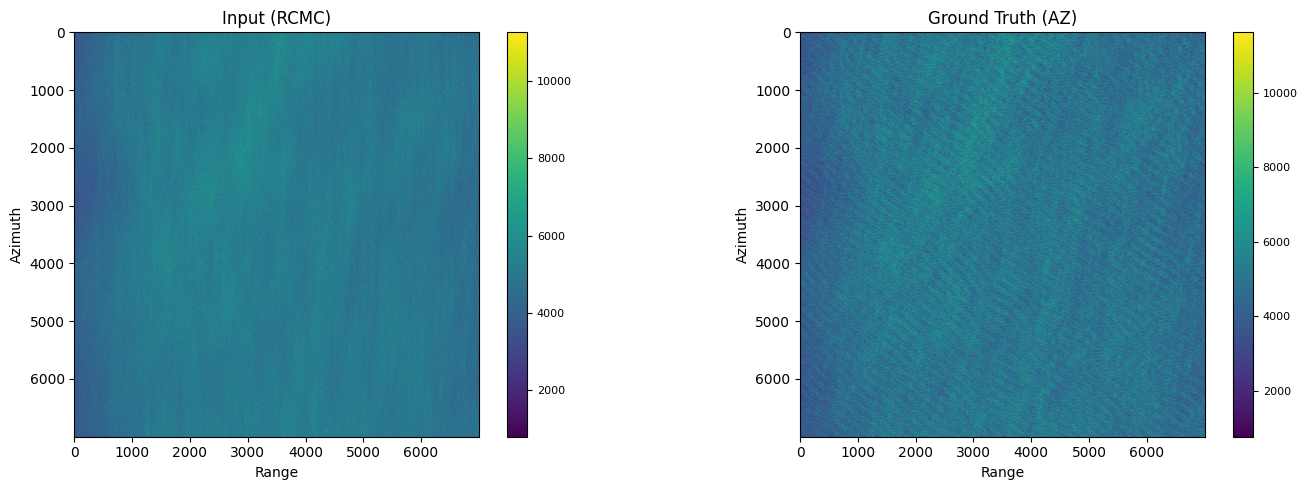

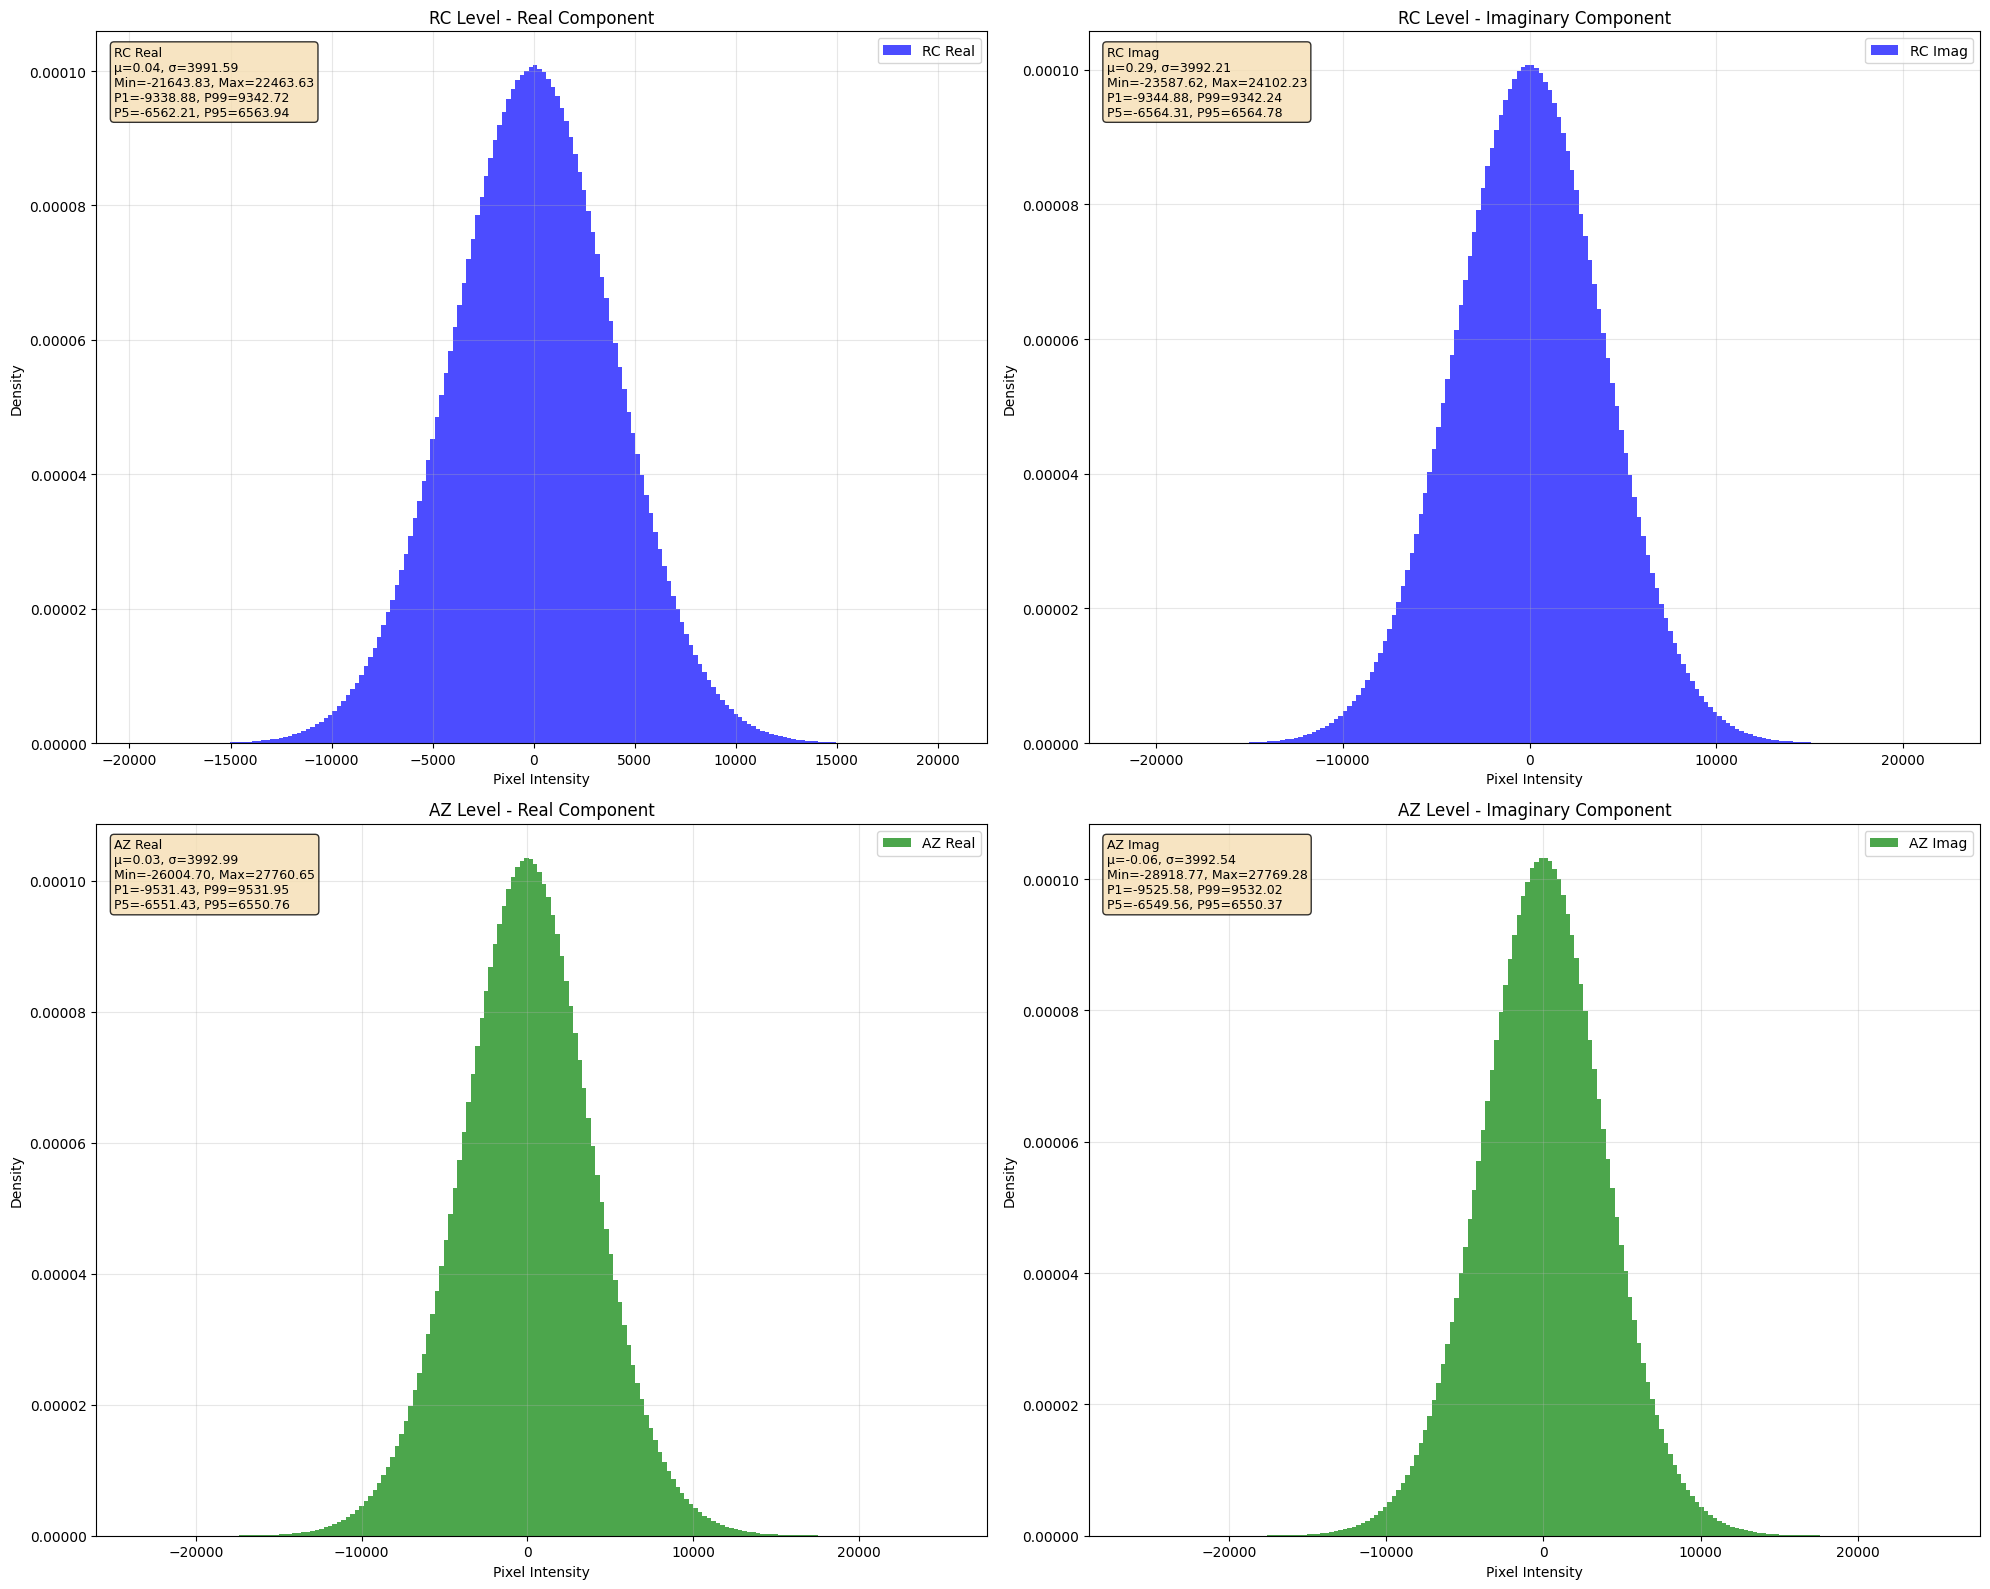

Displaying sample from product /Data/sar_focusing/PT1/s1a-s2-raw-s-vh-20250126t140023-20250126t140048-057616-07195b.zarr


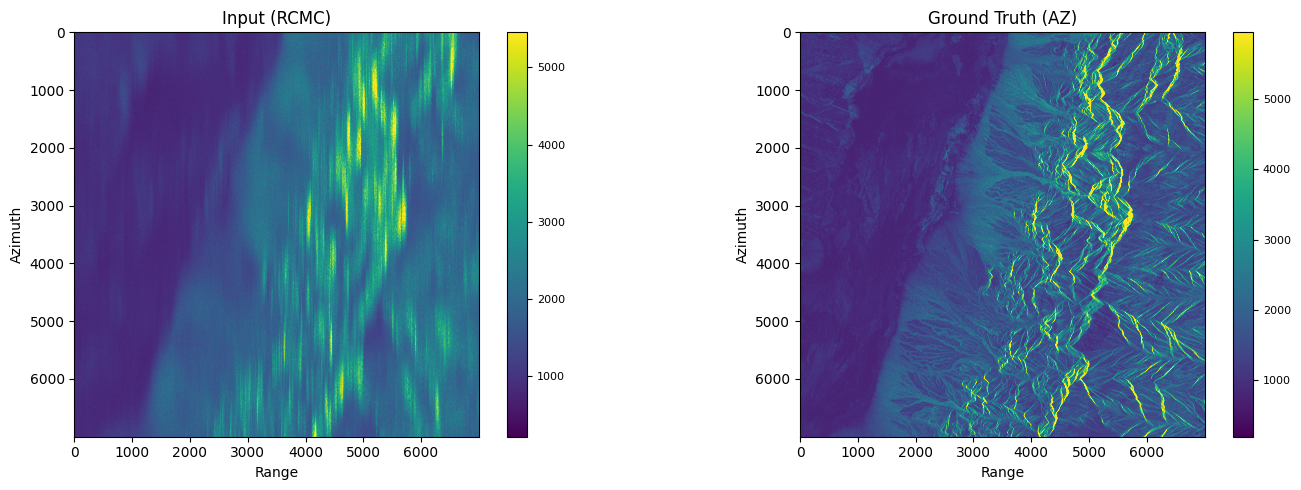

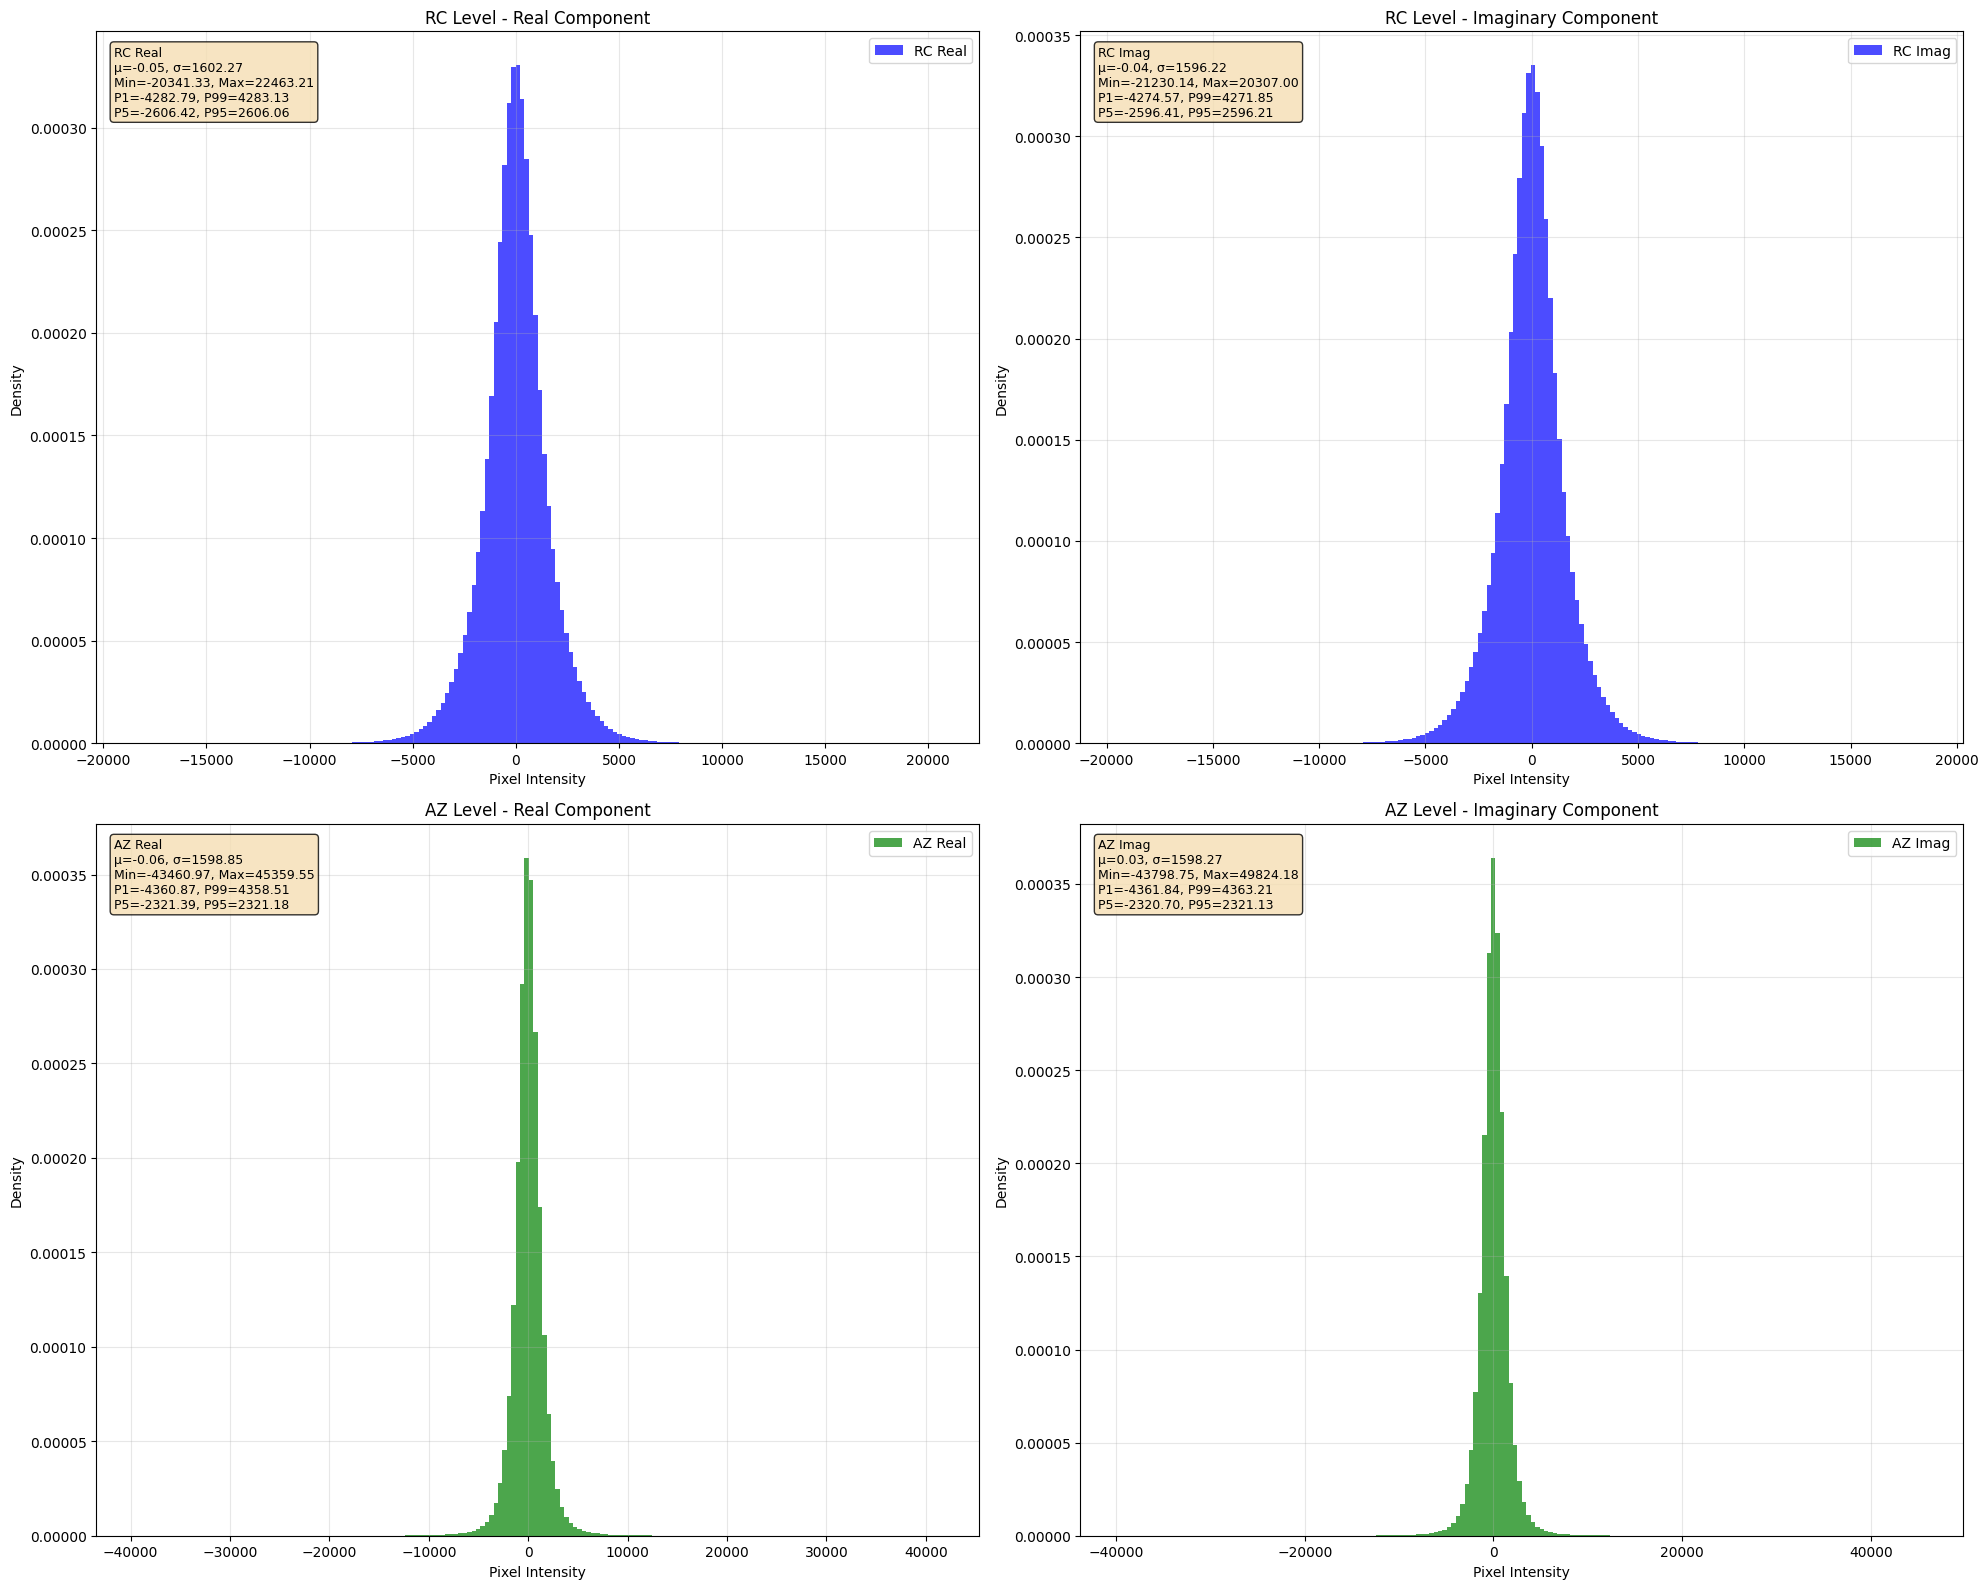

Checking metadata in s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/71.4M [00:00<?, ?B/s]

Checking metadata in s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/rc


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Checking metadata in s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/az


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Trying to download file s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/rc/c/0/0 from repo Maya4/PT1


s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/rc/c/0/1 from repo Maya4/PT1


s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/rc/c/1/0 from repo Maya4/PT1


s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/rc/c/1/1 from repo Maya4/PT1


s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/az/c/0/0 from repo Maya4/PT1


s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/az/c/0/1 from repo Maya4/PT1


s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/az/c/1/0 from repo Maya4/PT1


s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr/az/c/1/1 from repo Maya4/PT1


s1a-s3-raw-s-vh-20240726t152909-20240726(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT1/s1a-s3-raw-s-vh-20240726t152909-20240726t152929-054933-06b0f7.zarr


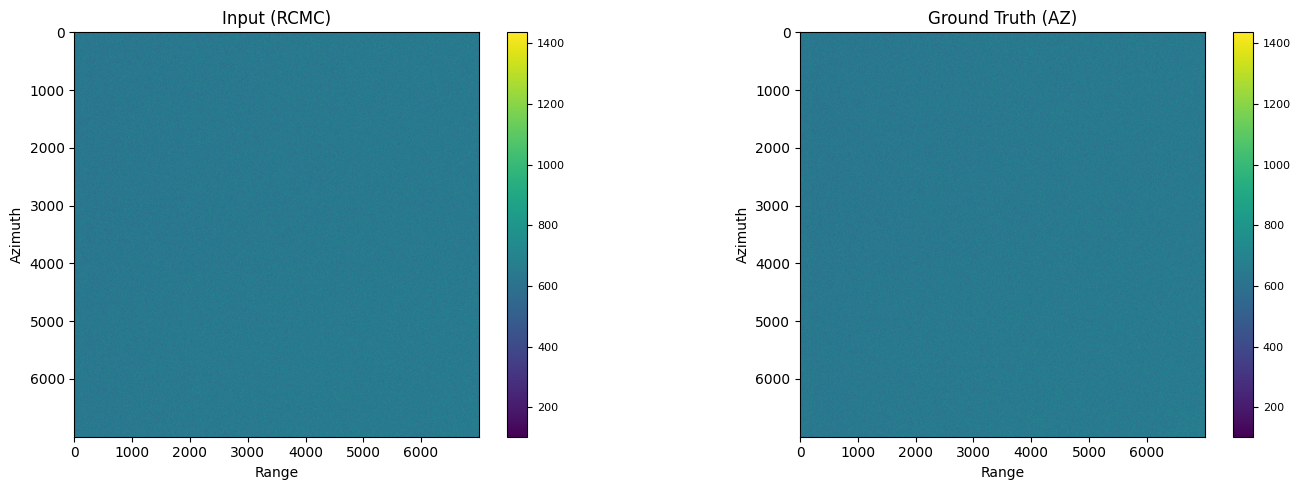

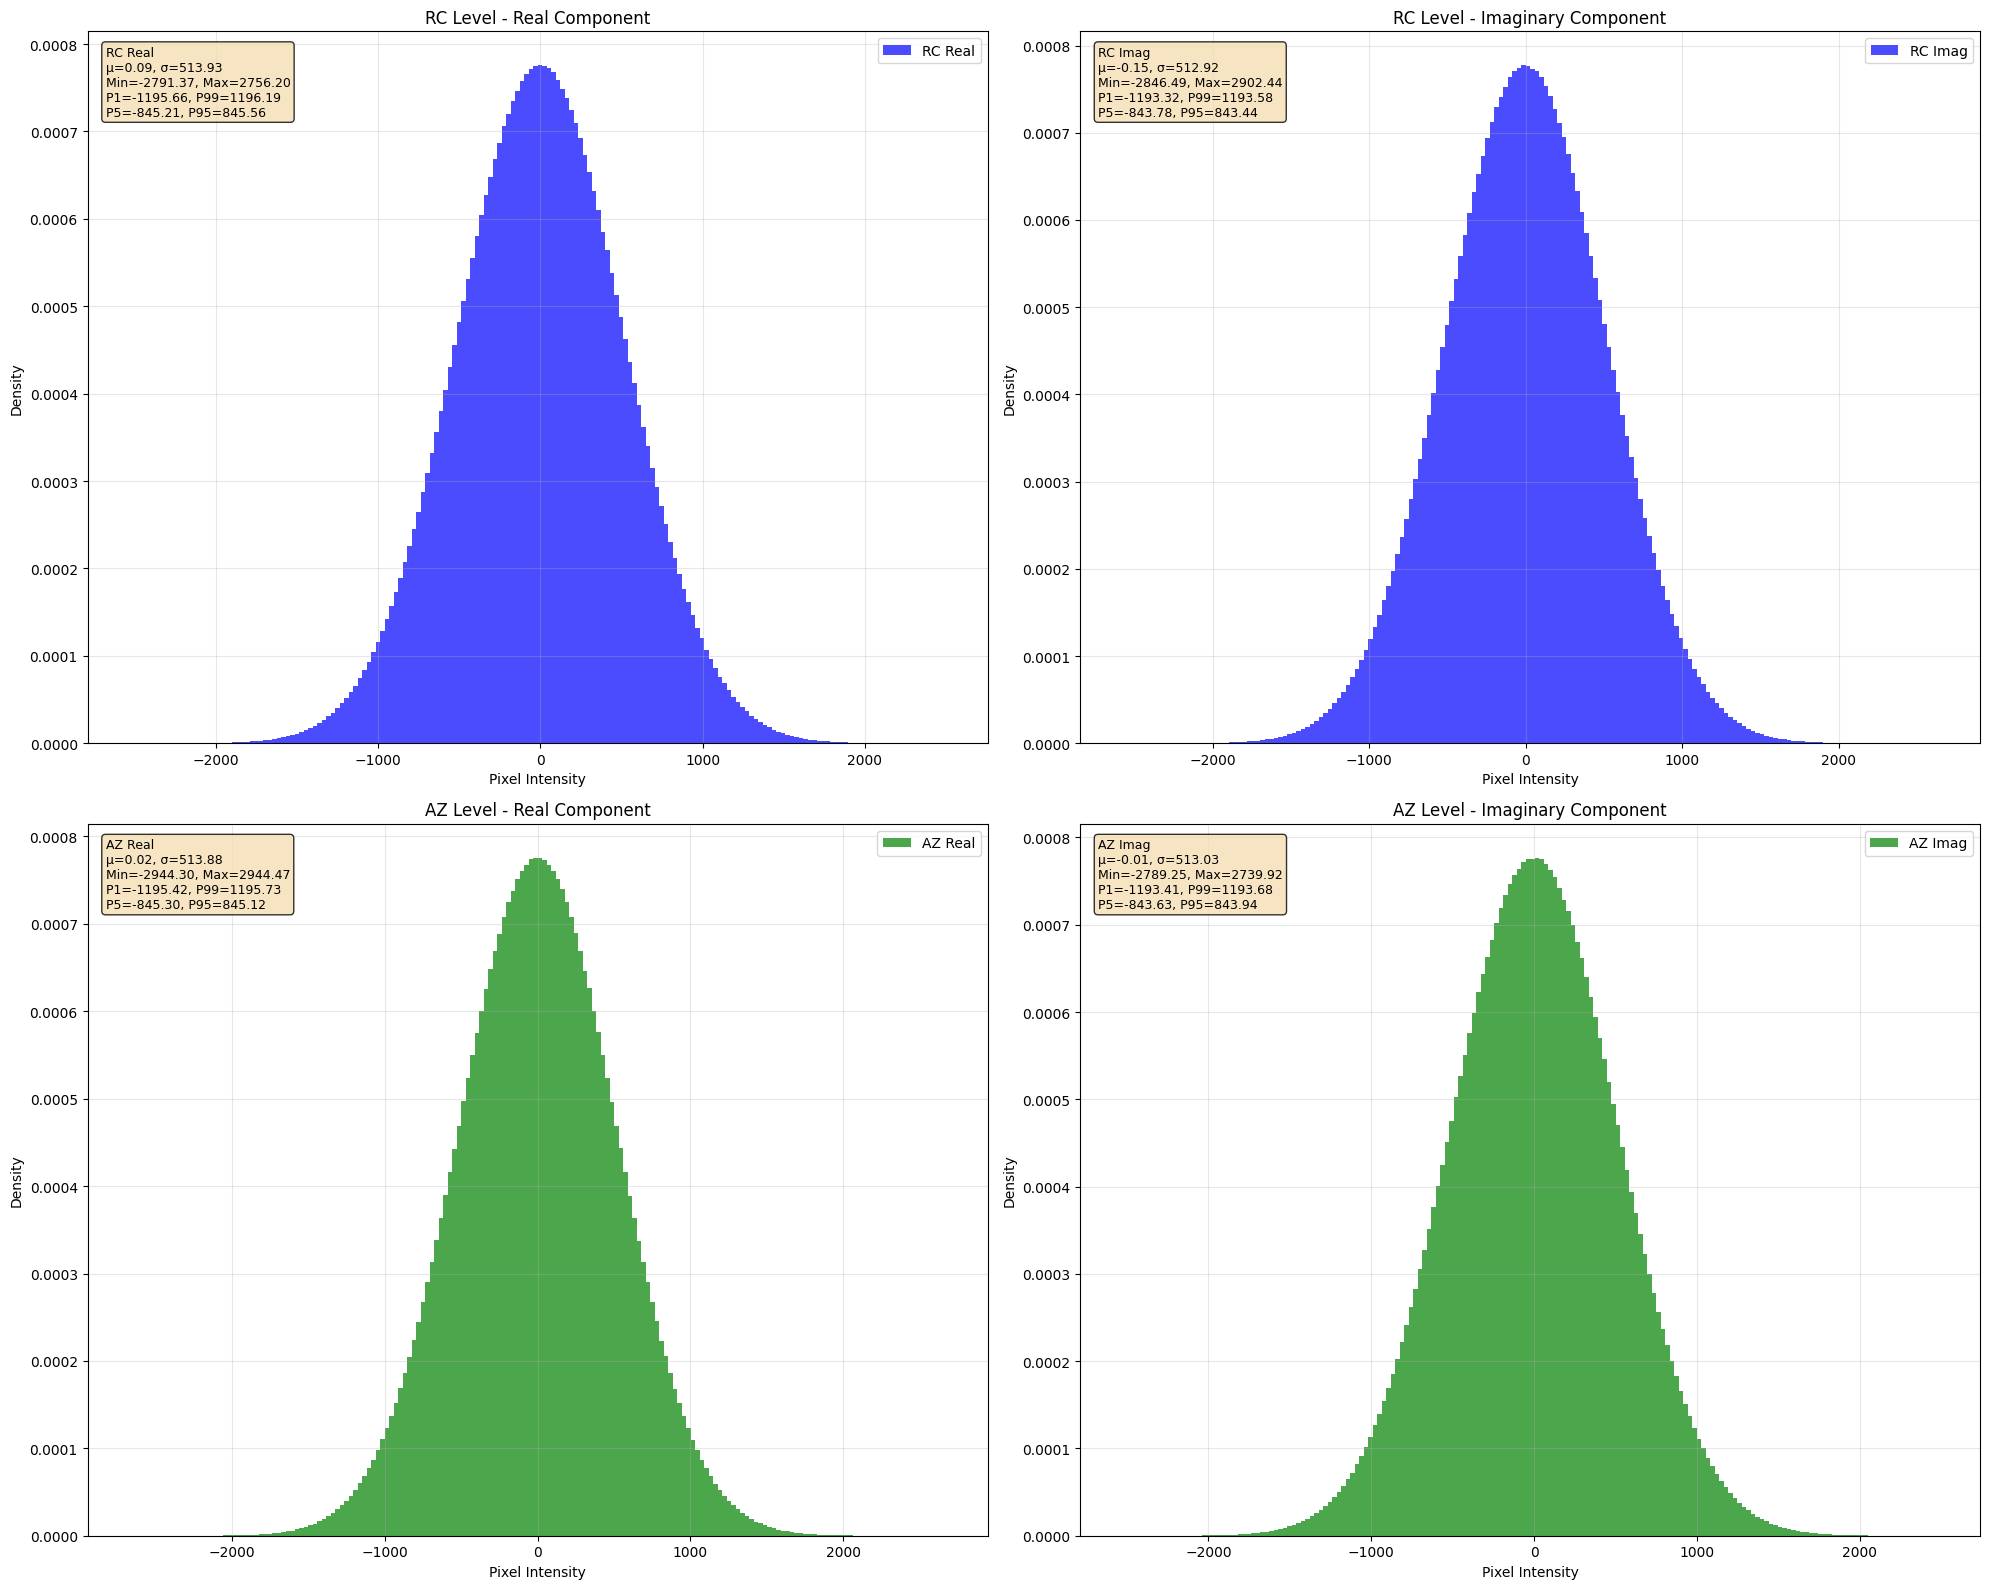

Checking metadata in s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr


\033Downloading .zattrs\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/29.4M [00:00<?, ?B/s]

\033Downloading .zgroup\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]       MB/s]

.zgroup:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

Checking metadata in s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/rc


\033Downloading .zattrs\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

.zattrs:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

\033Downloading .zarray\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]    1B/s]

.zarray:   0%|          | 0.00/340 [00:00<?, ?B/s]

Checking metadata in s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/az


\033Downloading .zattrs\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

.zattrs:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

\033Downloading .zarray\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]    7B/s]

.zarray:   0%|          | 0.00/340 [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/rc/0.0 from repo Maya4/PT1


s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/rc/0.1 from repo Maya4/PT1


s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/rc/1.0 from repo Maya4/PT1


s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/rc/1.1 from repo Maya4/PT1


s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/az/0.0 from repo Maya4/PT1


s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/az/0.1 from repo Maya4/PT1


s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/az/1.0 from repo Maya4/PT1


s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr/az/1.1 from repo Maya4/PT1


s1a-s4-raw-s-vh-20231219t183640-20231219(…):   0%|          | 0.00/241M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT1/s1a-s4-raw-s-vh-20231219t183640-20231219t183650-051727-063f59.zarr


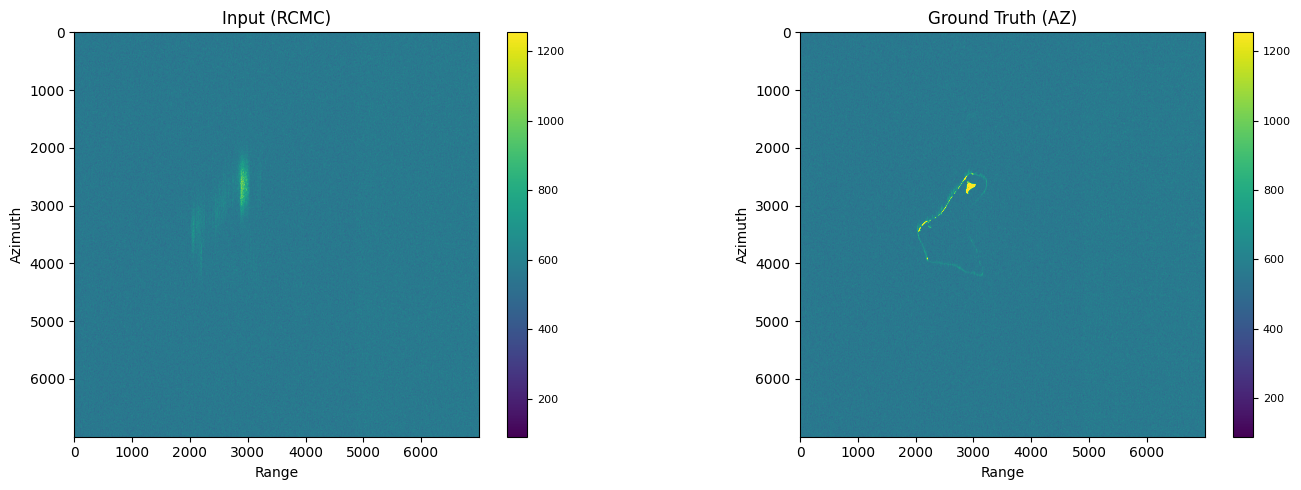

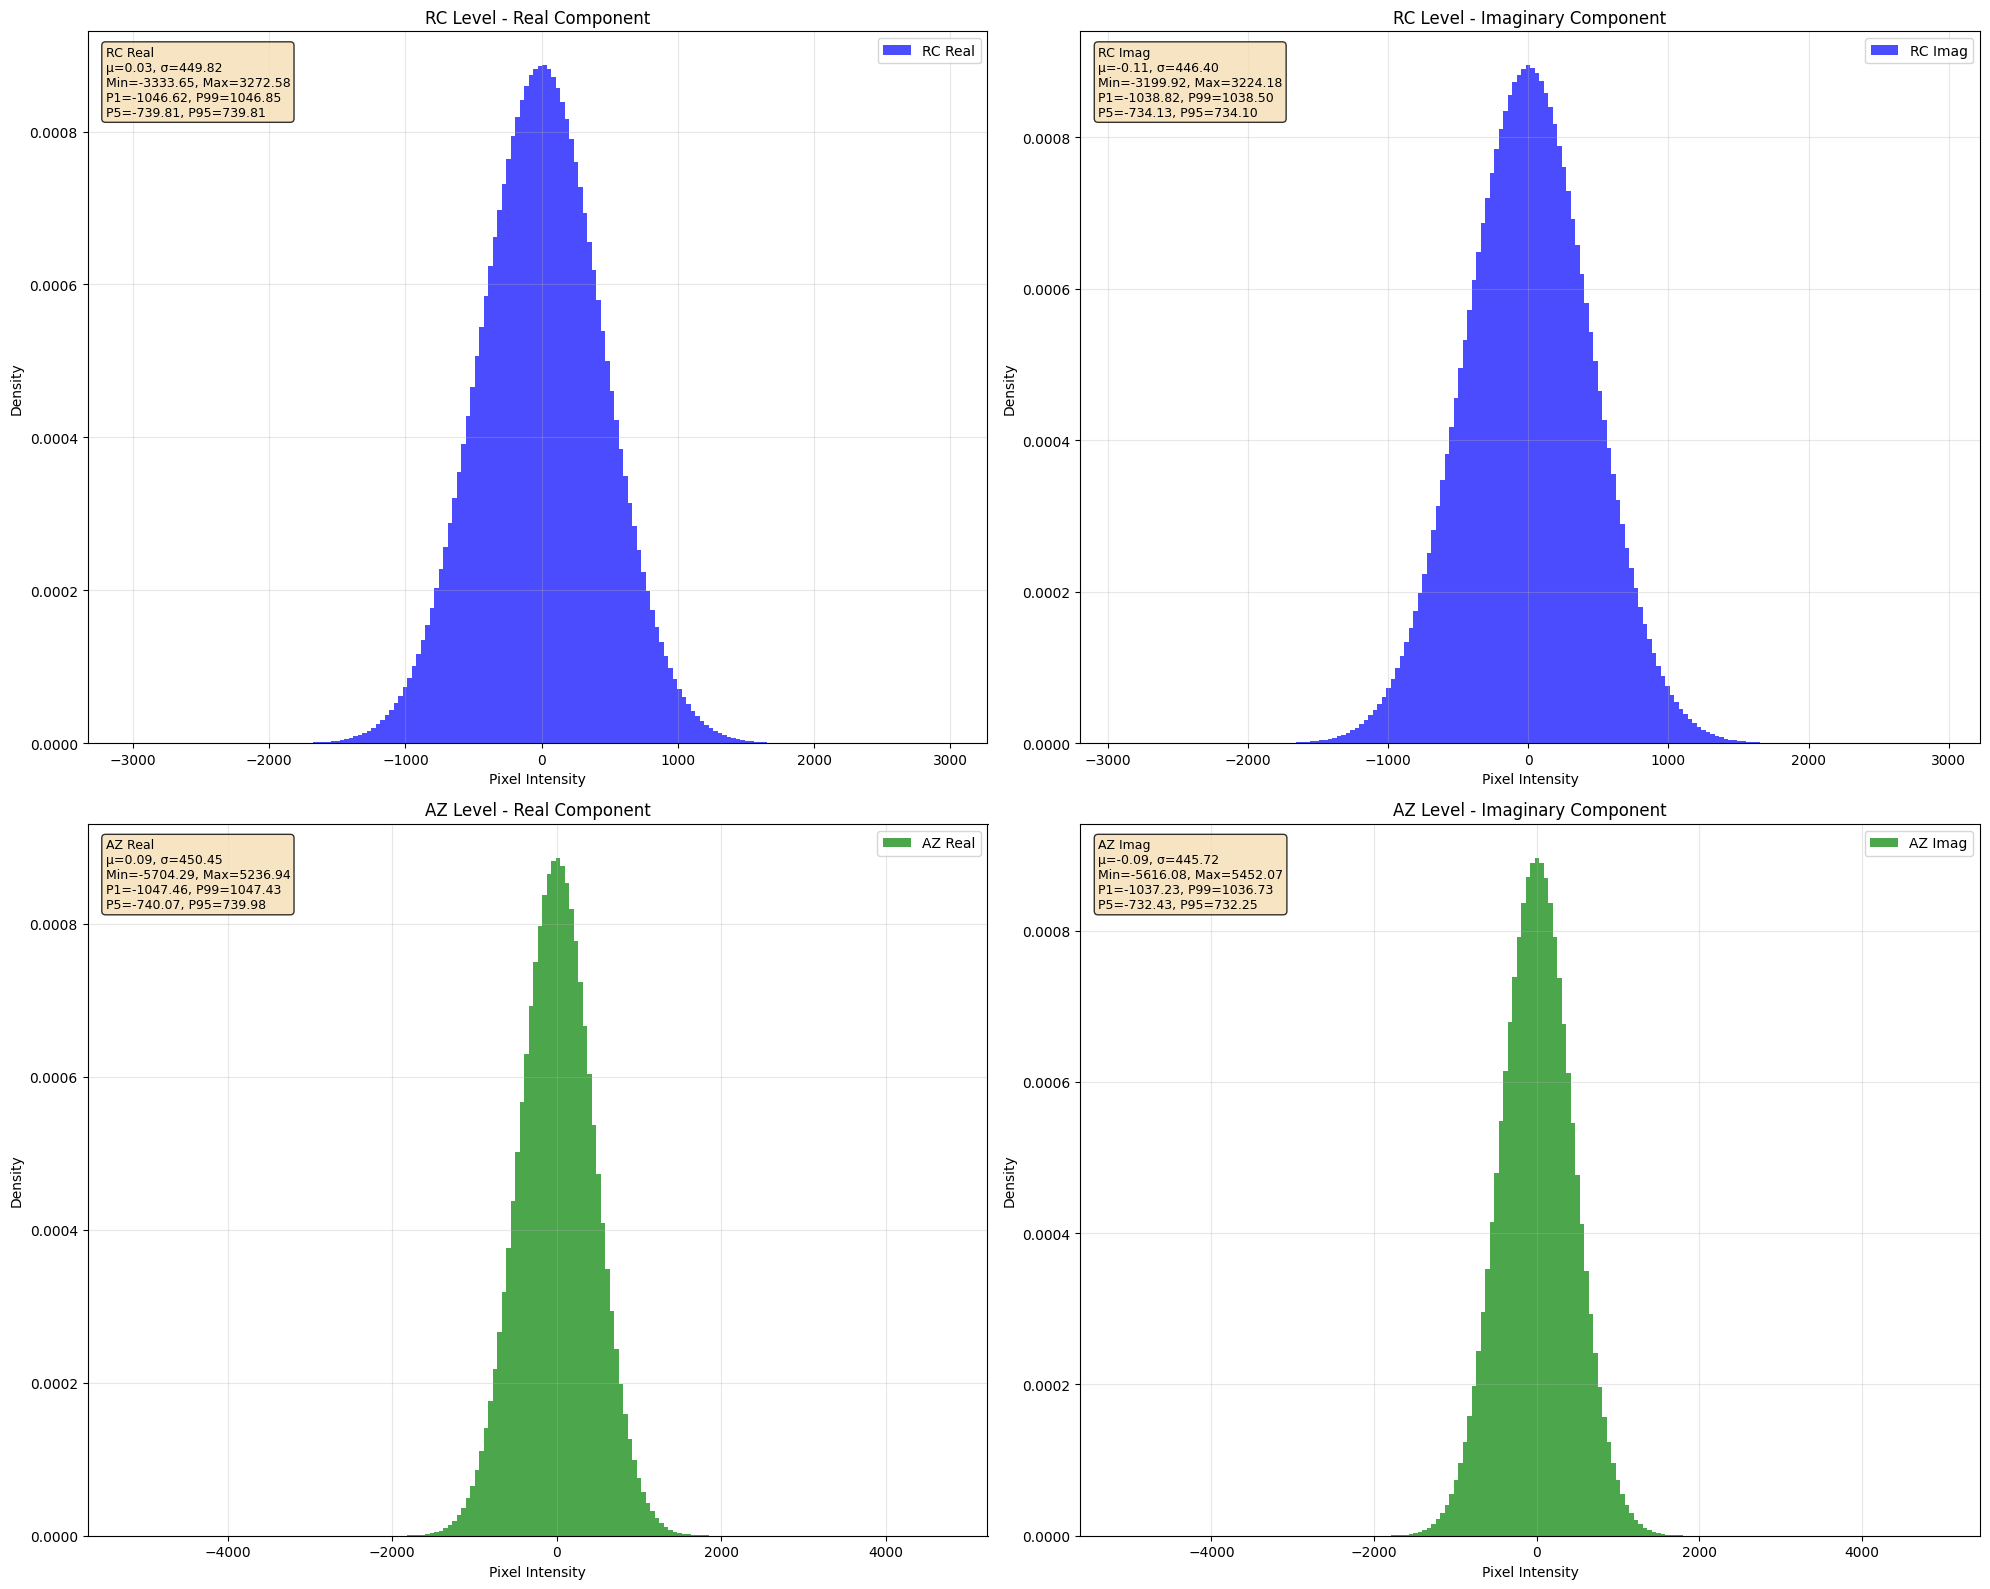

Checking metadata in s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/74.7M [00:00<?, ?B/s]

Checking metadata in s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/rc


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Checking metadata in s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/az


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/rc/c/0/0 from repo Maya4/PT2


s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/rc/c/0/1 from repo Maya4/PT2


s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/239M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/rc/c/1/0 from repo Maya4/PT2


s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/rc/c/1/1 from repo Maya4/PT2


s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/239M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/az/c/0/0 from repo Maya4/PT2


s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/az/c/0/1 from repo Maya4/PT2


s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/239M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/az/c/1/0 from repo Maya4/PT2


s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr/az/c/1/1 from repo Maya4/PT2


s1a-s2-raw-s-hh-20230326t213531-20230326(…):   0%|          | 0.00/239M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT2/s1a-s2-raw-s-hh-20230326t213531-20230326t213557-047821-05bed7.zarr


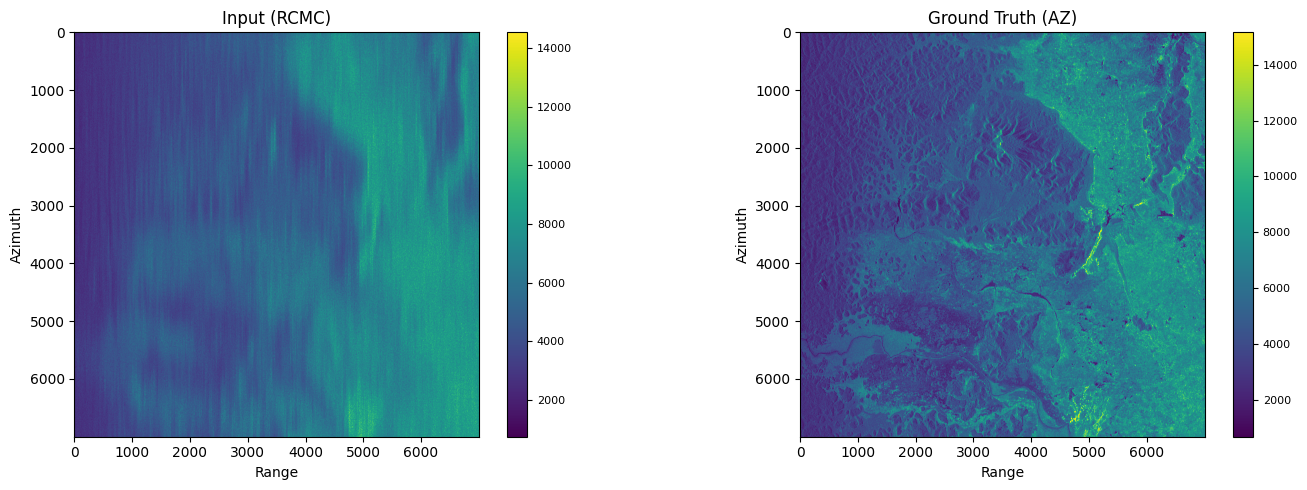

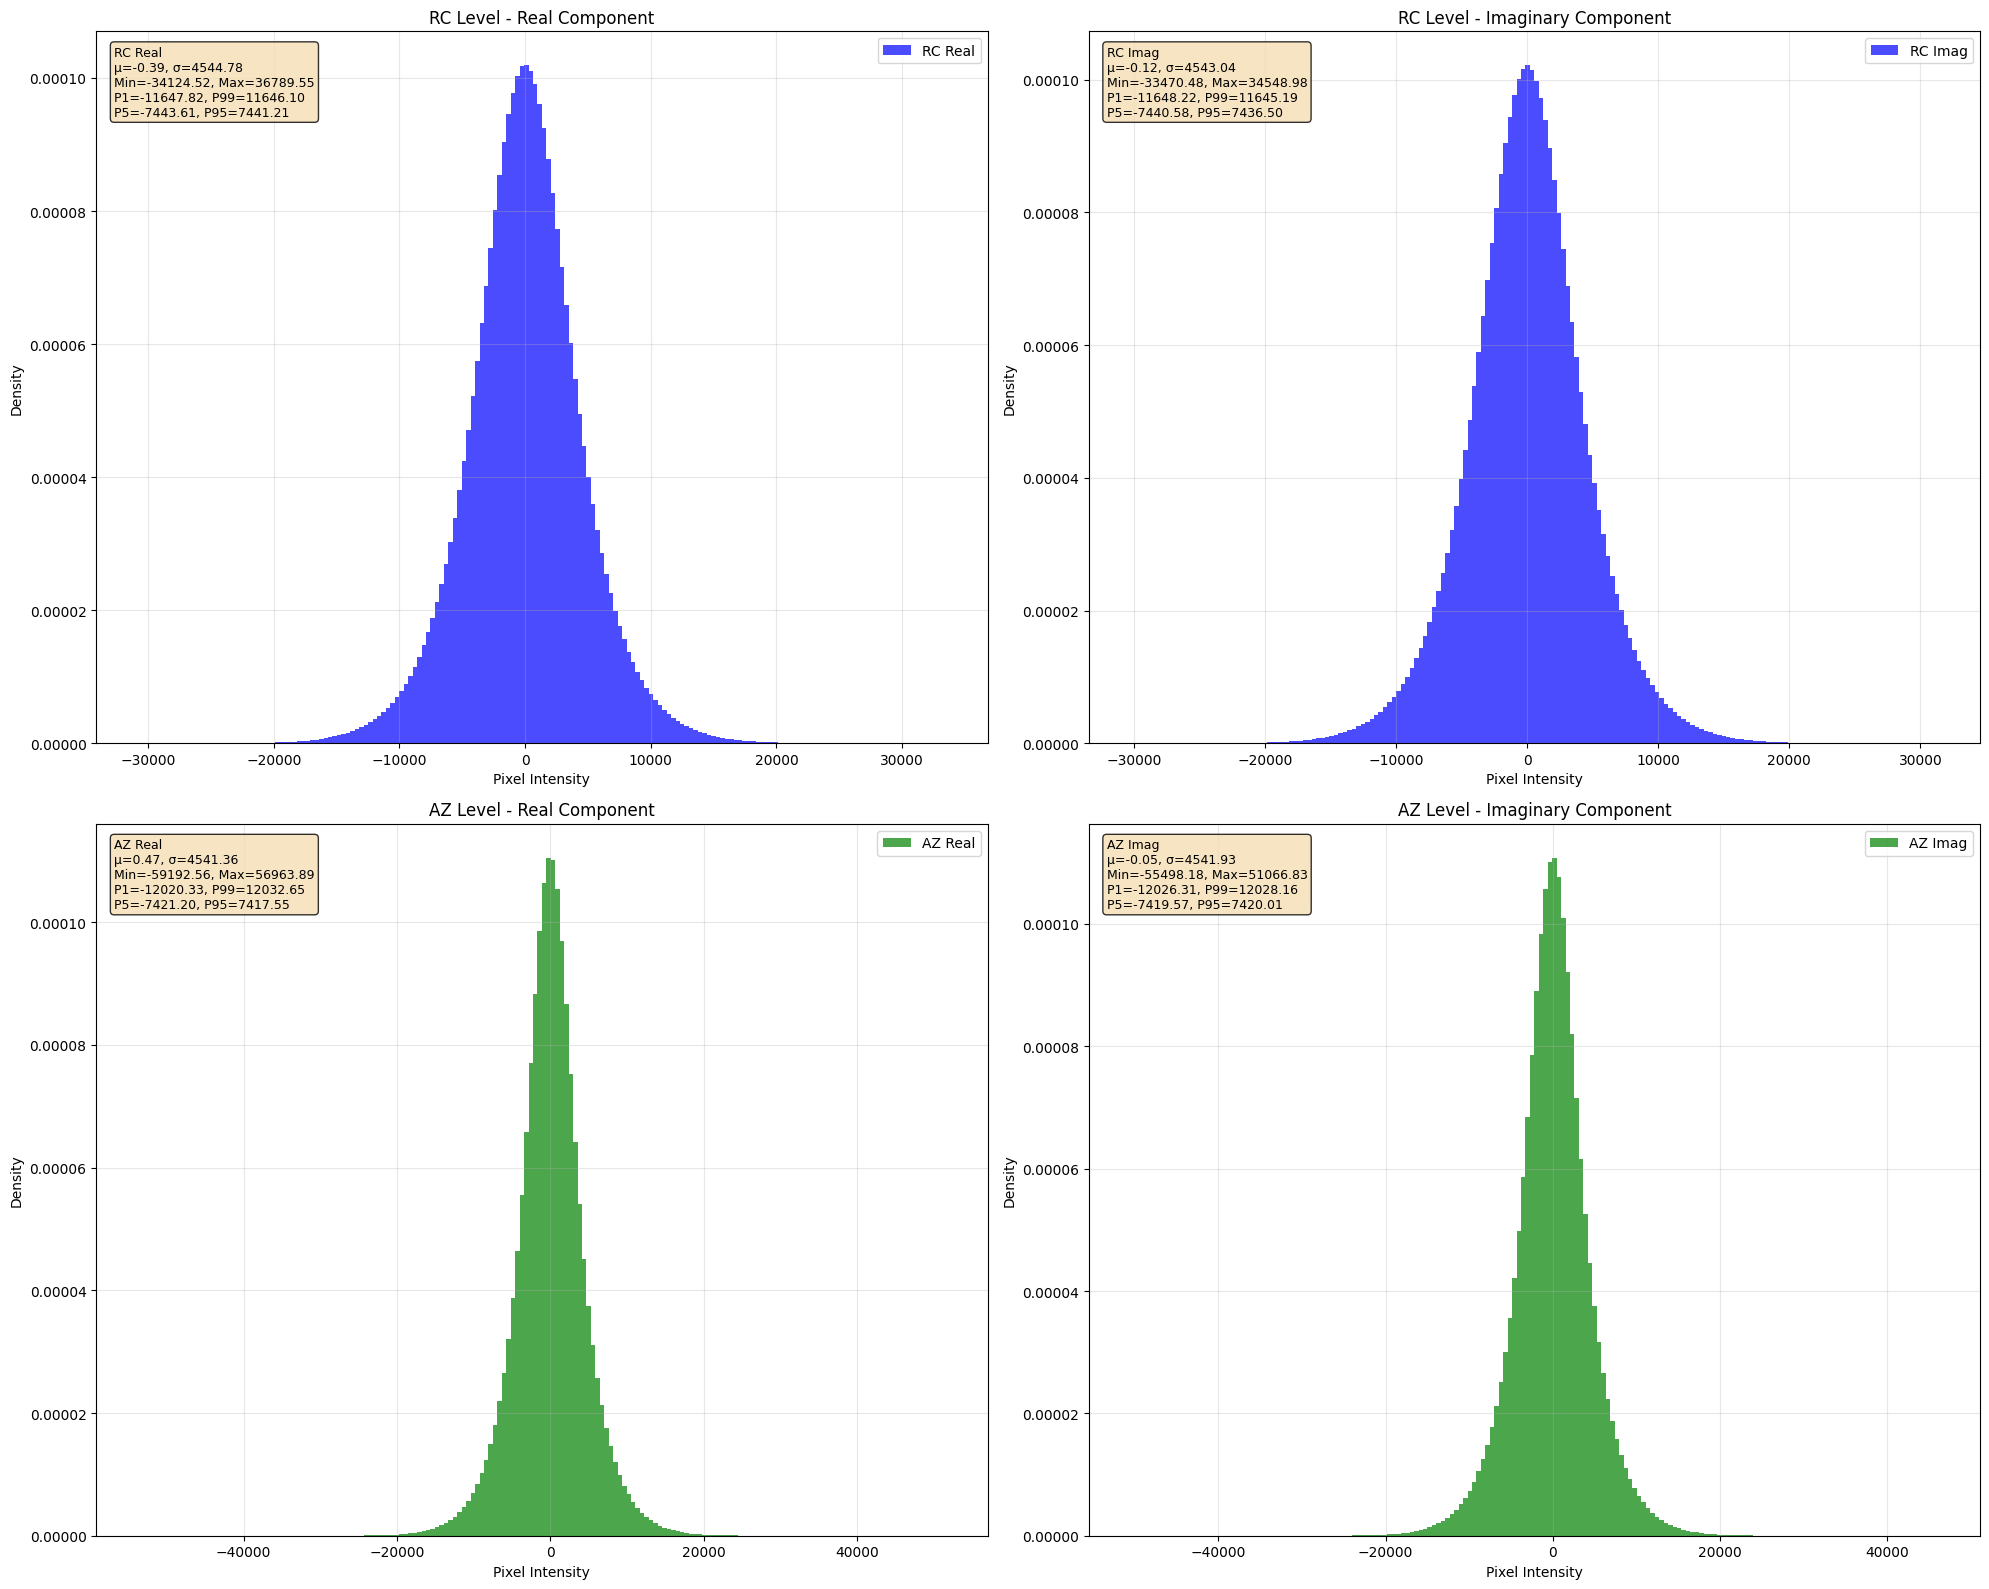

Trying to download file s1a-s2-raw-s-hh-20240808t052250-20240808t052323-055117-06b756.zarr/rc/c/1/1 from repo Maya4/PT2


s1a-s2-raw-s-hh-20240808t052250-20240808(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-hh-20240808t052250-20240808t052323-055117-06b756.zarr/az/c/1/1 from repo Maya4/PT2


s1a-s2-raw-s-hh-20240808t052250-20240808(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT2/s1a-s2-raw-s-hh-20240808t052250-20240808t052323-055117-06b756.zarr


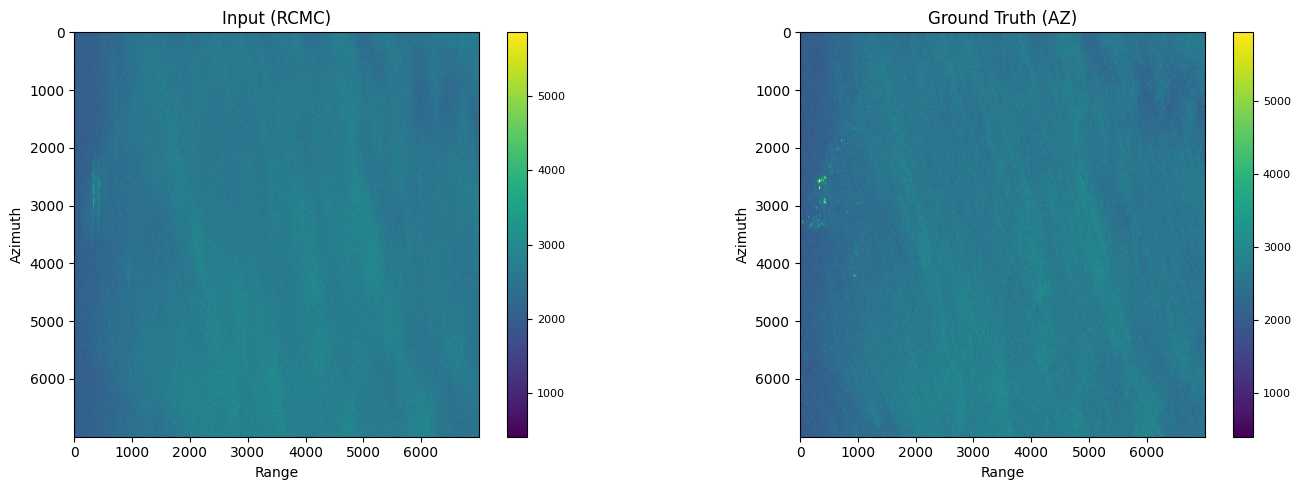

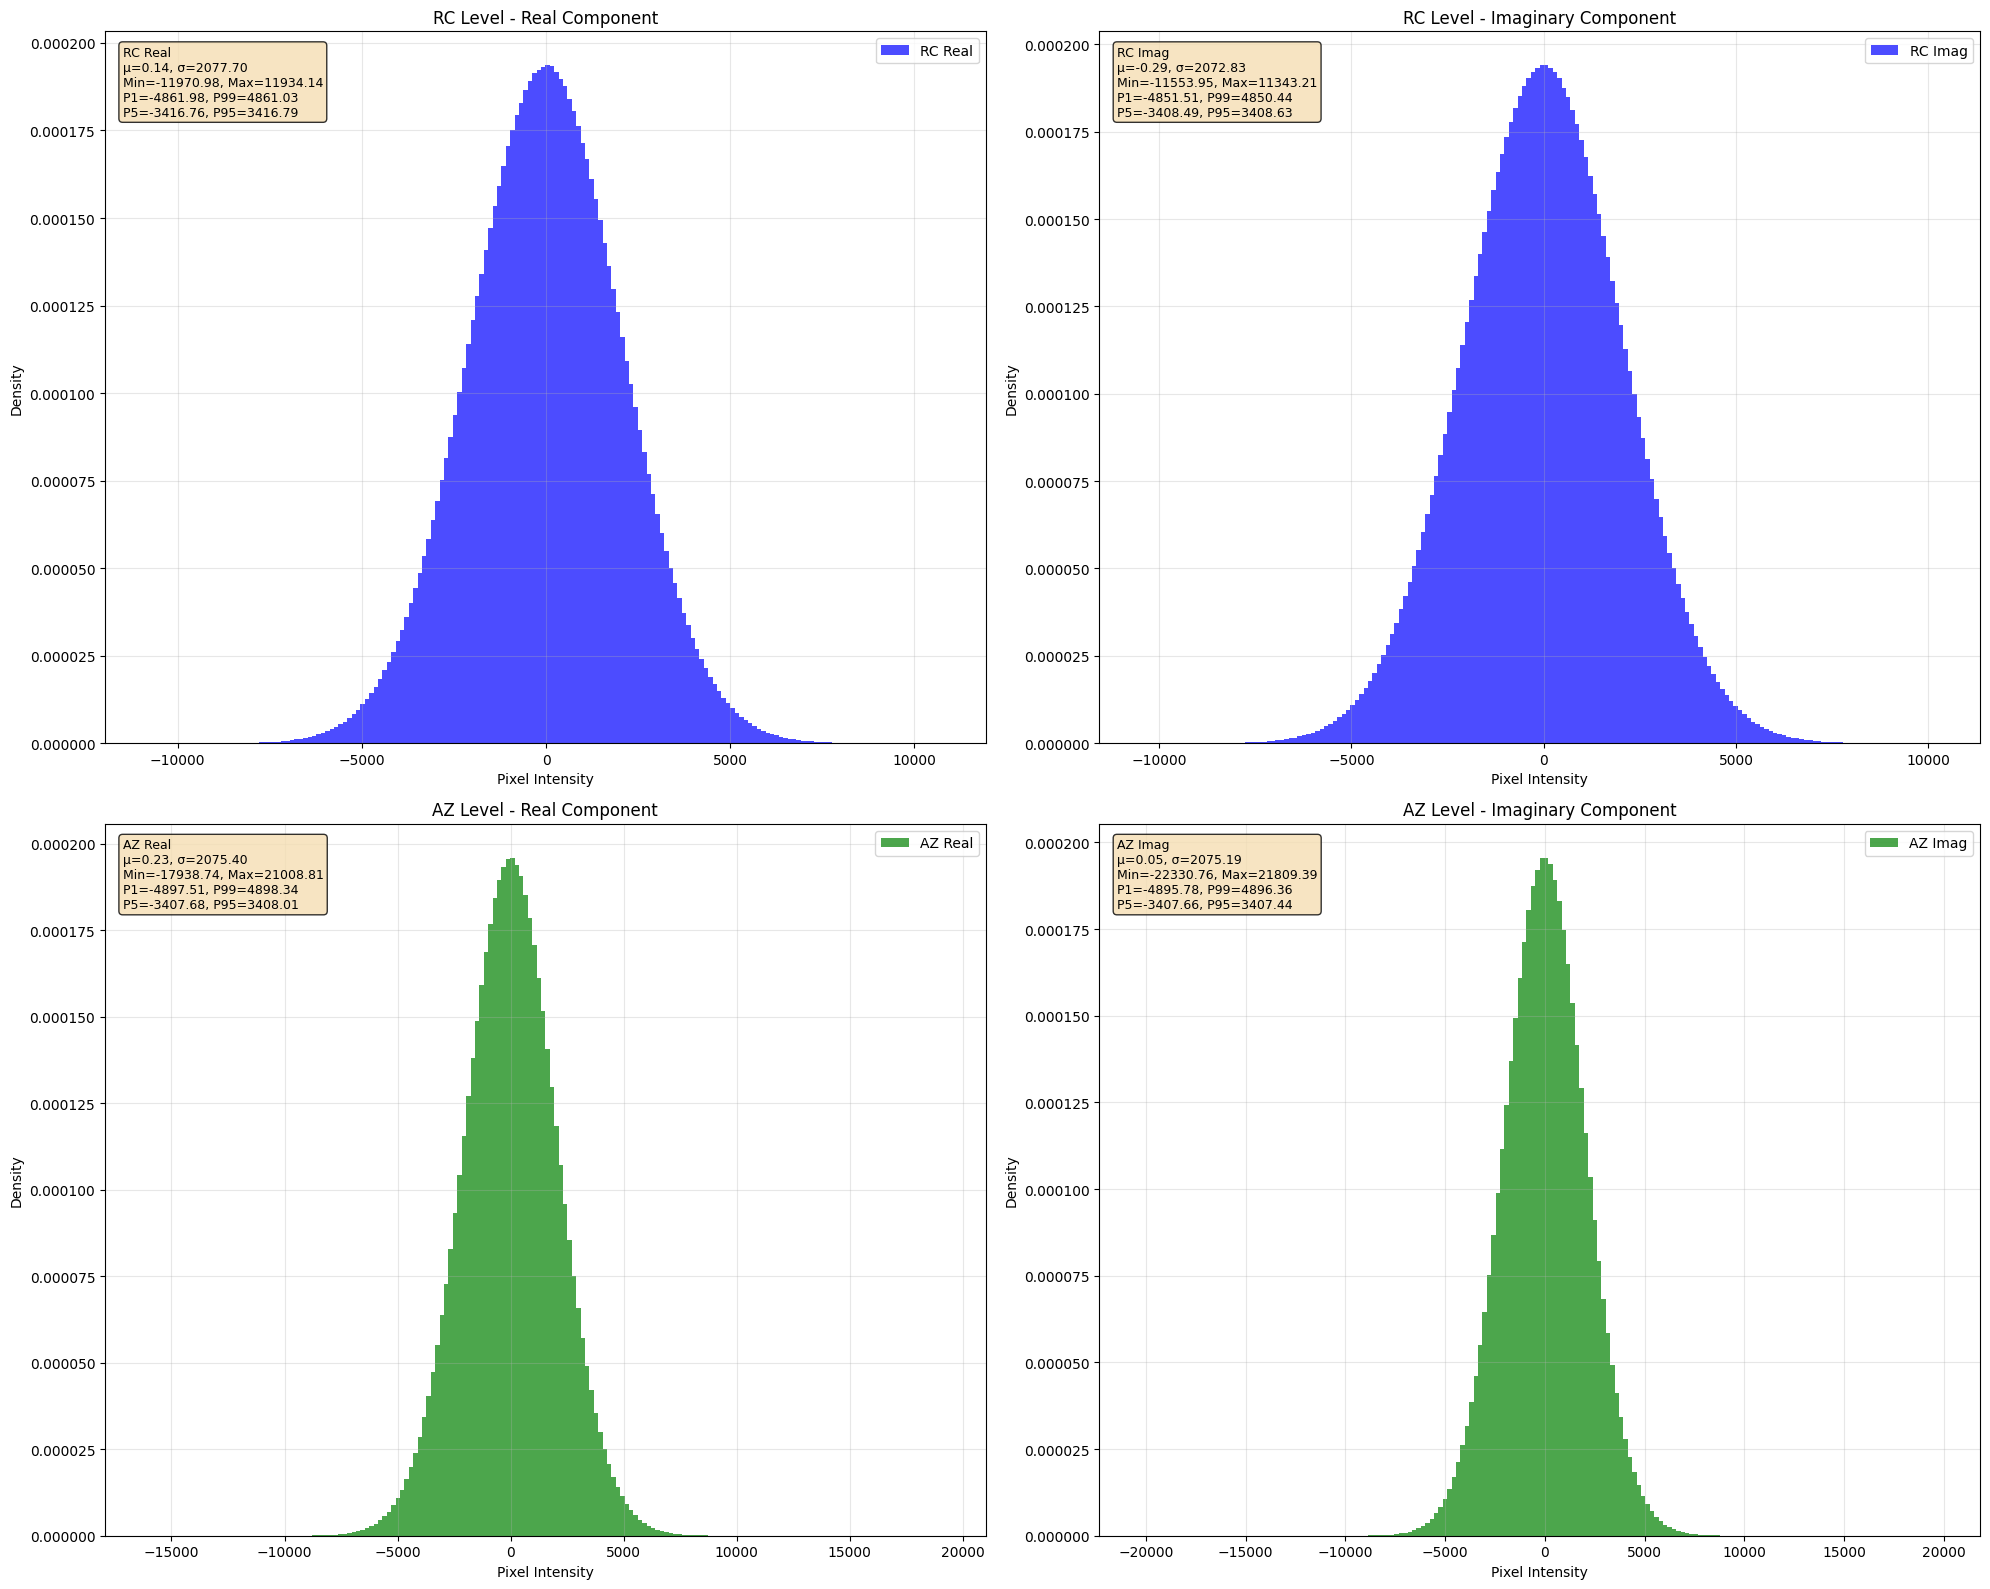

Checking metadata in s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/59.8M [00:00<?, ?B/s]

Checking metadata in s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/rc


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Checking metadata in s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/az


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/rc/c/0/0 from repo Maya4/PT2


s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/rc/c/0/1 from repo Maya4/PT2


s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/rc/c/1/0 from repo Maya4/PT2


s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/rc/c/1/1 from repo Maya4/PT2


s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/az/c/0/0 from repo Maya4/PT2


s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/az/c/0/1 from repo Maya4/PT2


s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/az/c/1/0 from repo Maya4/PT2


s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr/az/c/1/1 from repo Maya4/PT2


s1a-s2-raw-s-vh-20241216t014915-20241216(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT2/s1a-s2-raw-s-vh-20241216t014915-20241216t014936-057011-070160.zarr


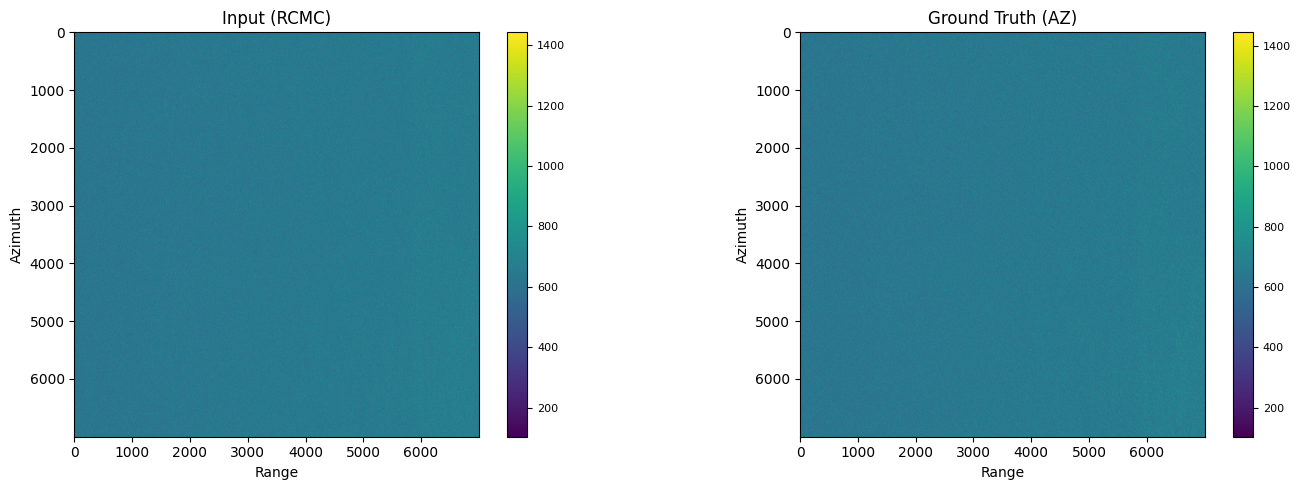

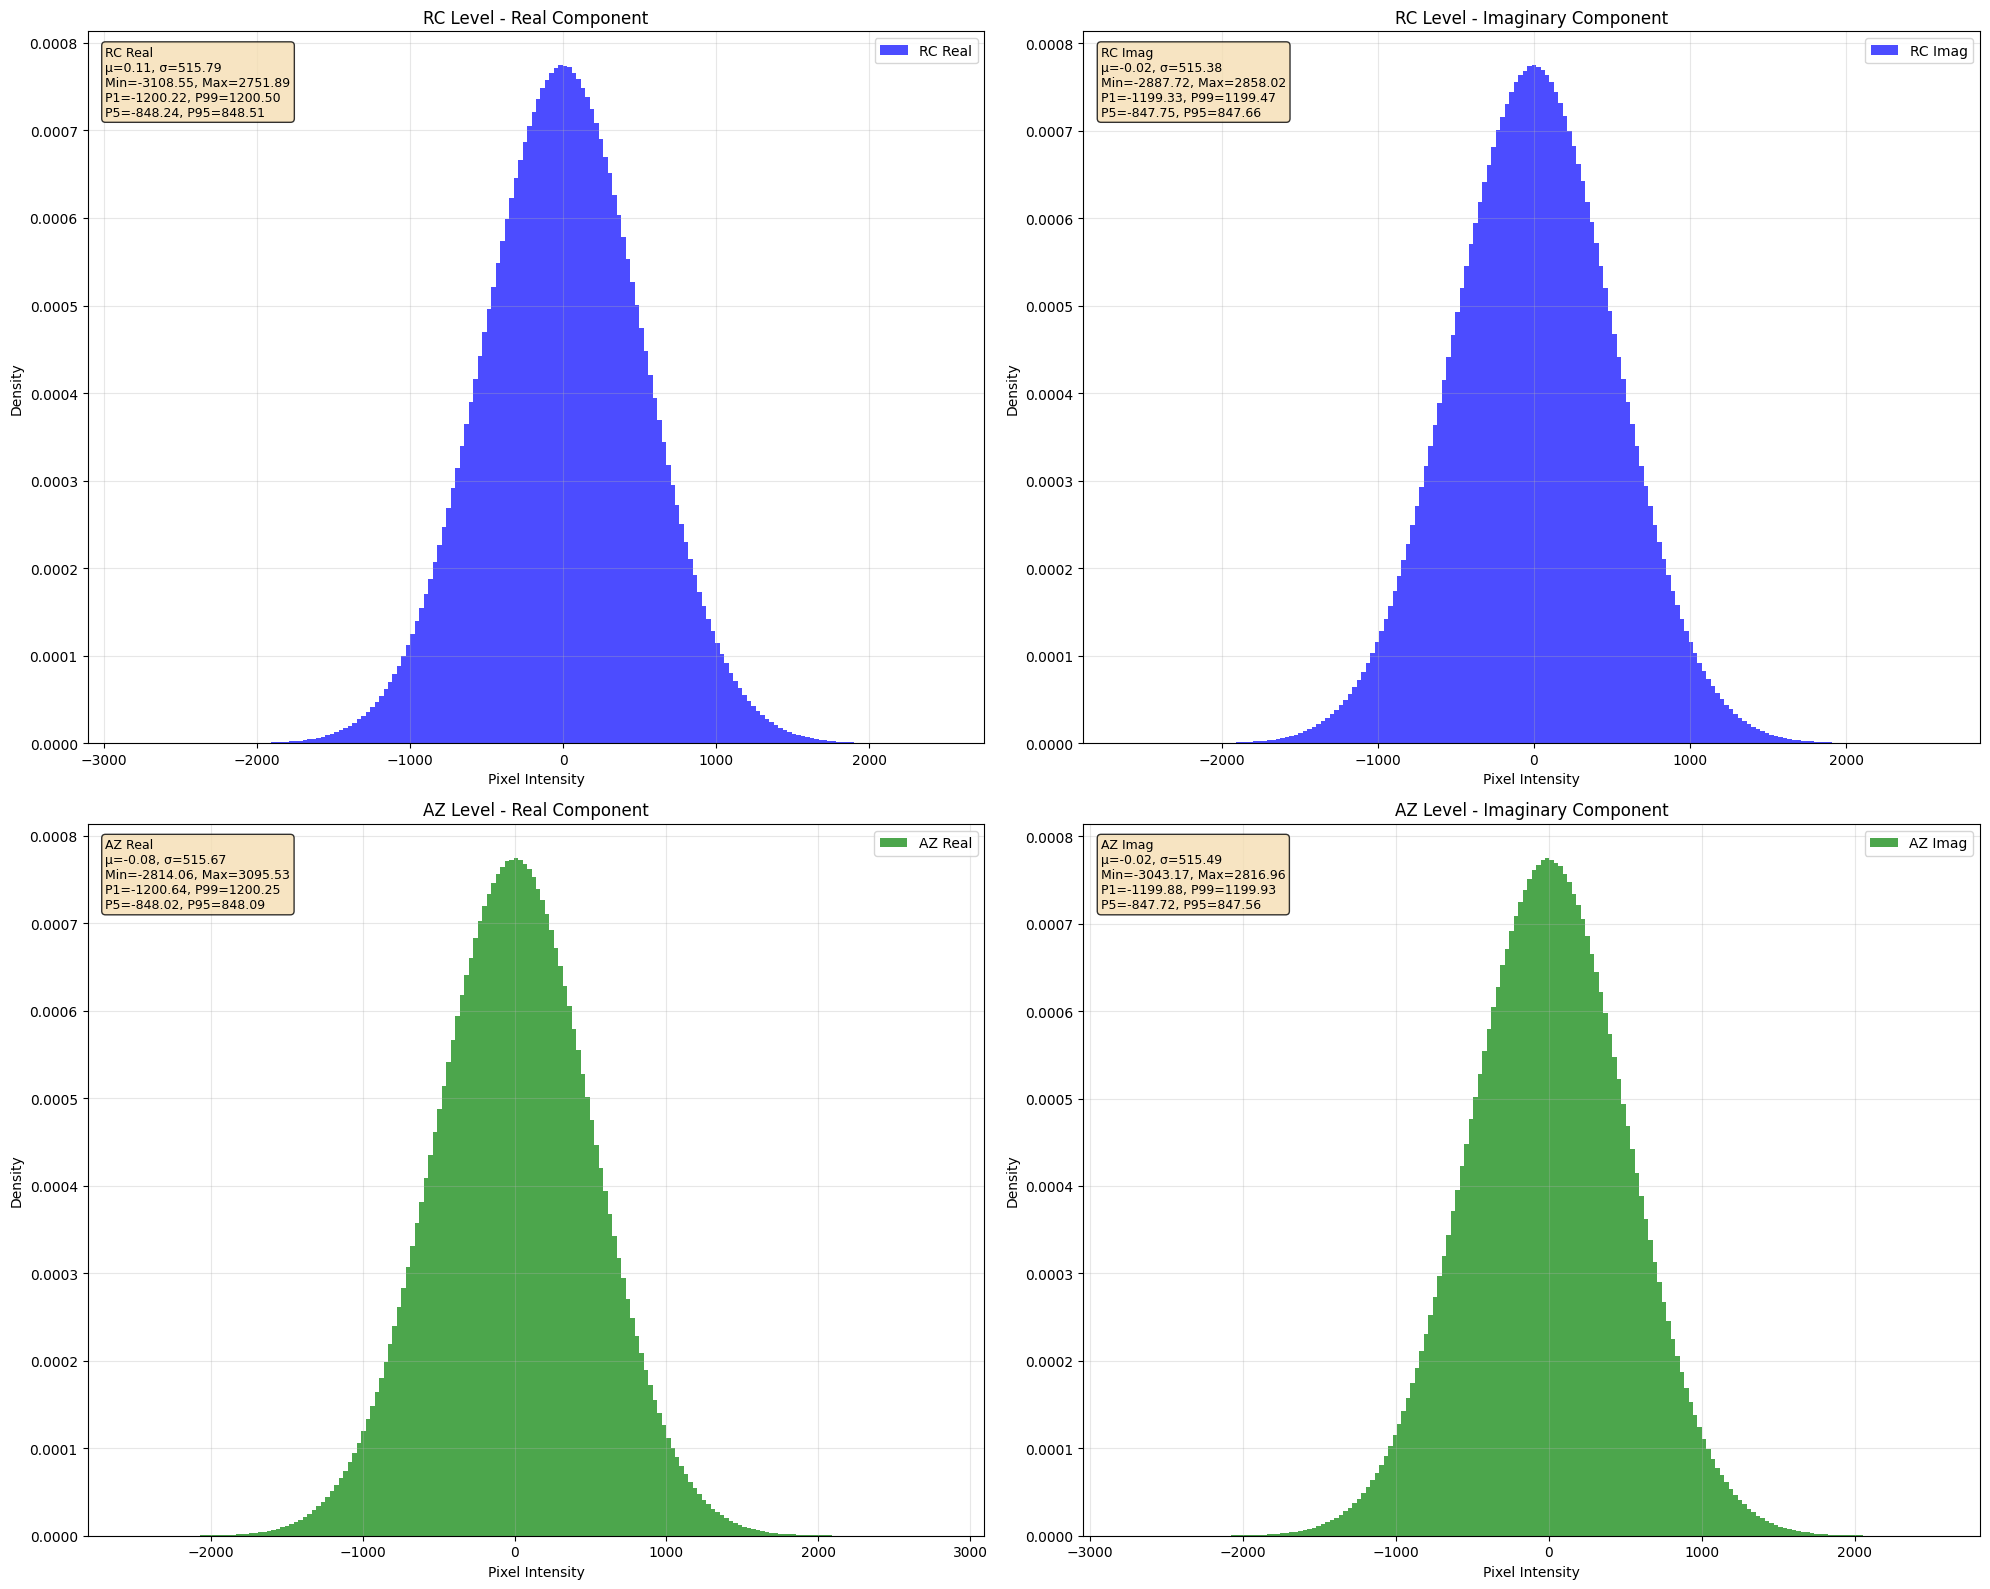

Checking metadata in s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/76.4M [00:00<?, ?B/s]

Checking metadata in s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/rc


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Checking metadata in s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/az


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/rc/c/0/0 from repo Maya4/PT2


s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/rc/c/0/1 from repo Maya4/PT2


s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/rc/c/1/0 from repo Maya4/PT2


s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/rc/c/1/1 from repo Maya4/PT2


s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/az/c/0/0 from repo Maya4/PT2


s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/az/c/0/1 from repo Maya4/PT2


s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/az/c/1/0 from repo Maya4/PT2


s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr/az/c/1/1 from repo Maya4/PT2


s1a-s4-raw-s-hh-20240814t234917-20240814(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT2/s1a-s4-raw-s-hh-20240814t234917-20240814t234943-055216-06baf7.zarr


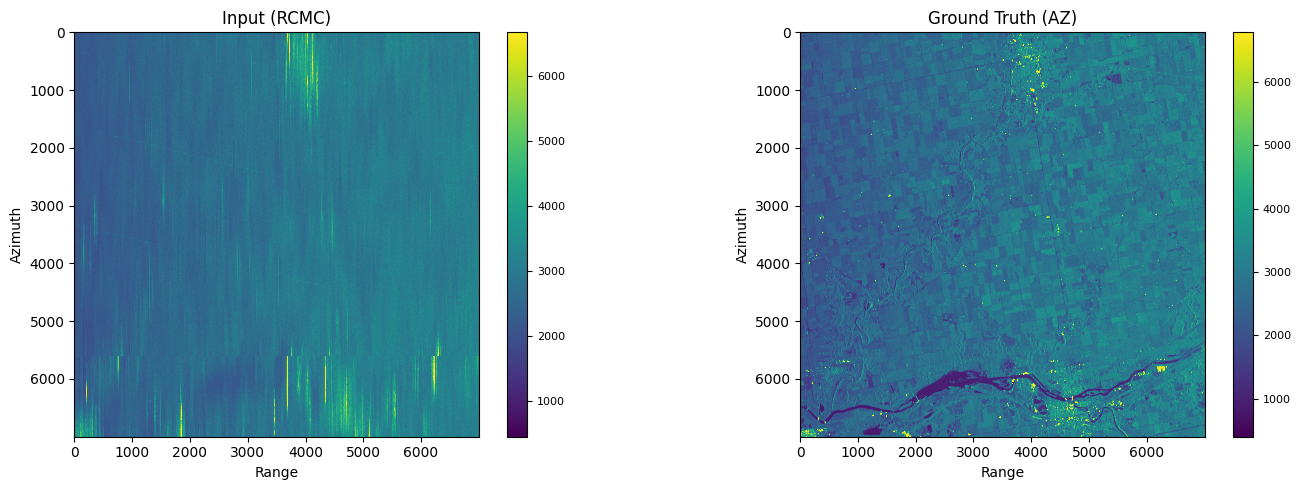

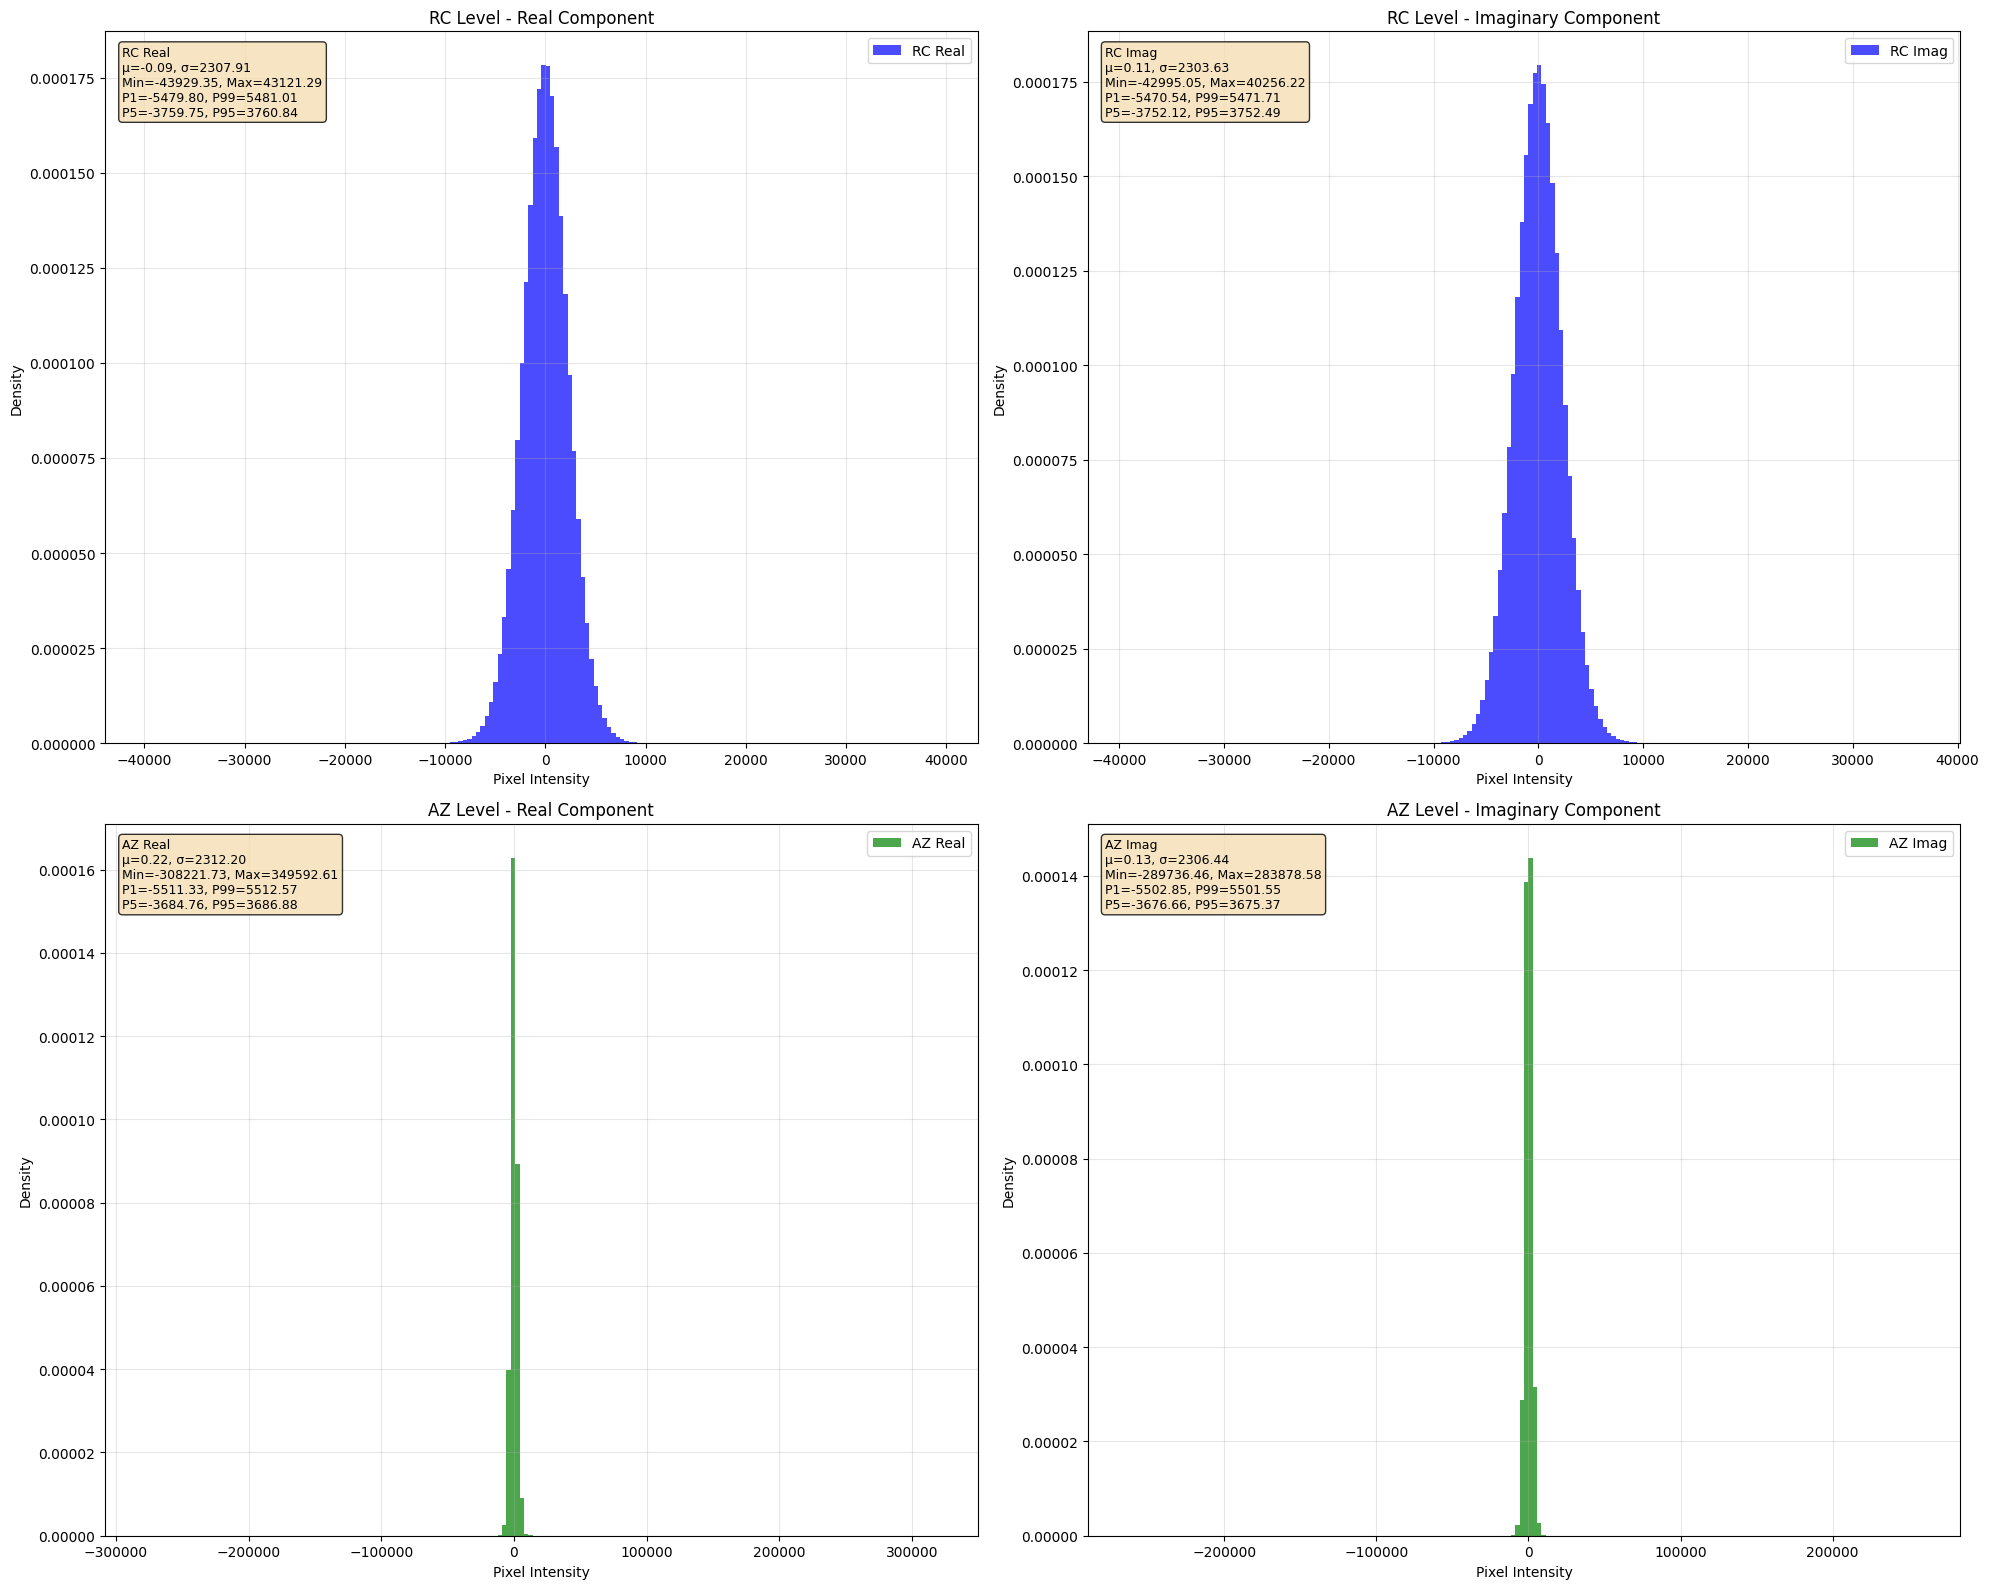

Checking metadata in s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/106M [00:00<?, ?B/s]

Checking metadata in s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/rc


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Checking metadata in s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/az


\033Downloading zarr.json\033: :   0%|          | 0.00/1.00 [00:00<?, ?B/s]

zarr.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

Trying to download file s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/rc/c/0/0 from repo Maya4/PT2


s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/rc/c/0/1 from repo Maya4/PT2


s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/rc/c/1/0 from repo Maya4/PT2


s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/rc/c/1/1 from repo Maya4/PT2


s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/az/c/0/0 from repo Maya4/PT2


s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/az/c/0/1 from repo Maya4/PT2


s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/az/c/1/0 from repo Maya4/PT2


s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr/az/c/1/1 from repo Maya4/PT2


s1a-s5-raw-s-vh-20231204t185336-20231204(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT2/s1a-s5-raw-s-vh-20231204t185336-20231204t185406-051508-0637a8.zarr


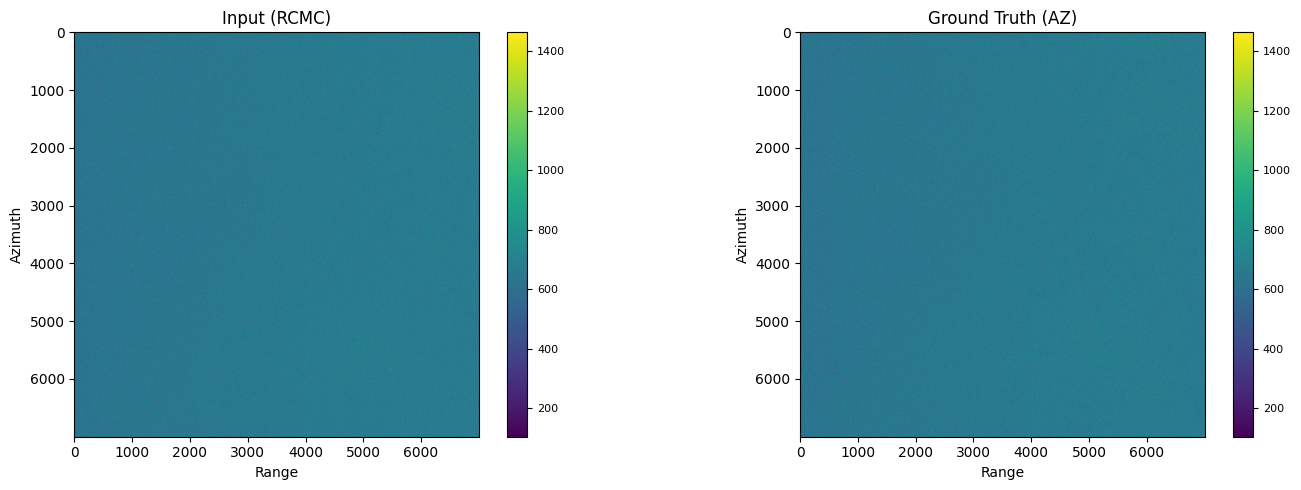

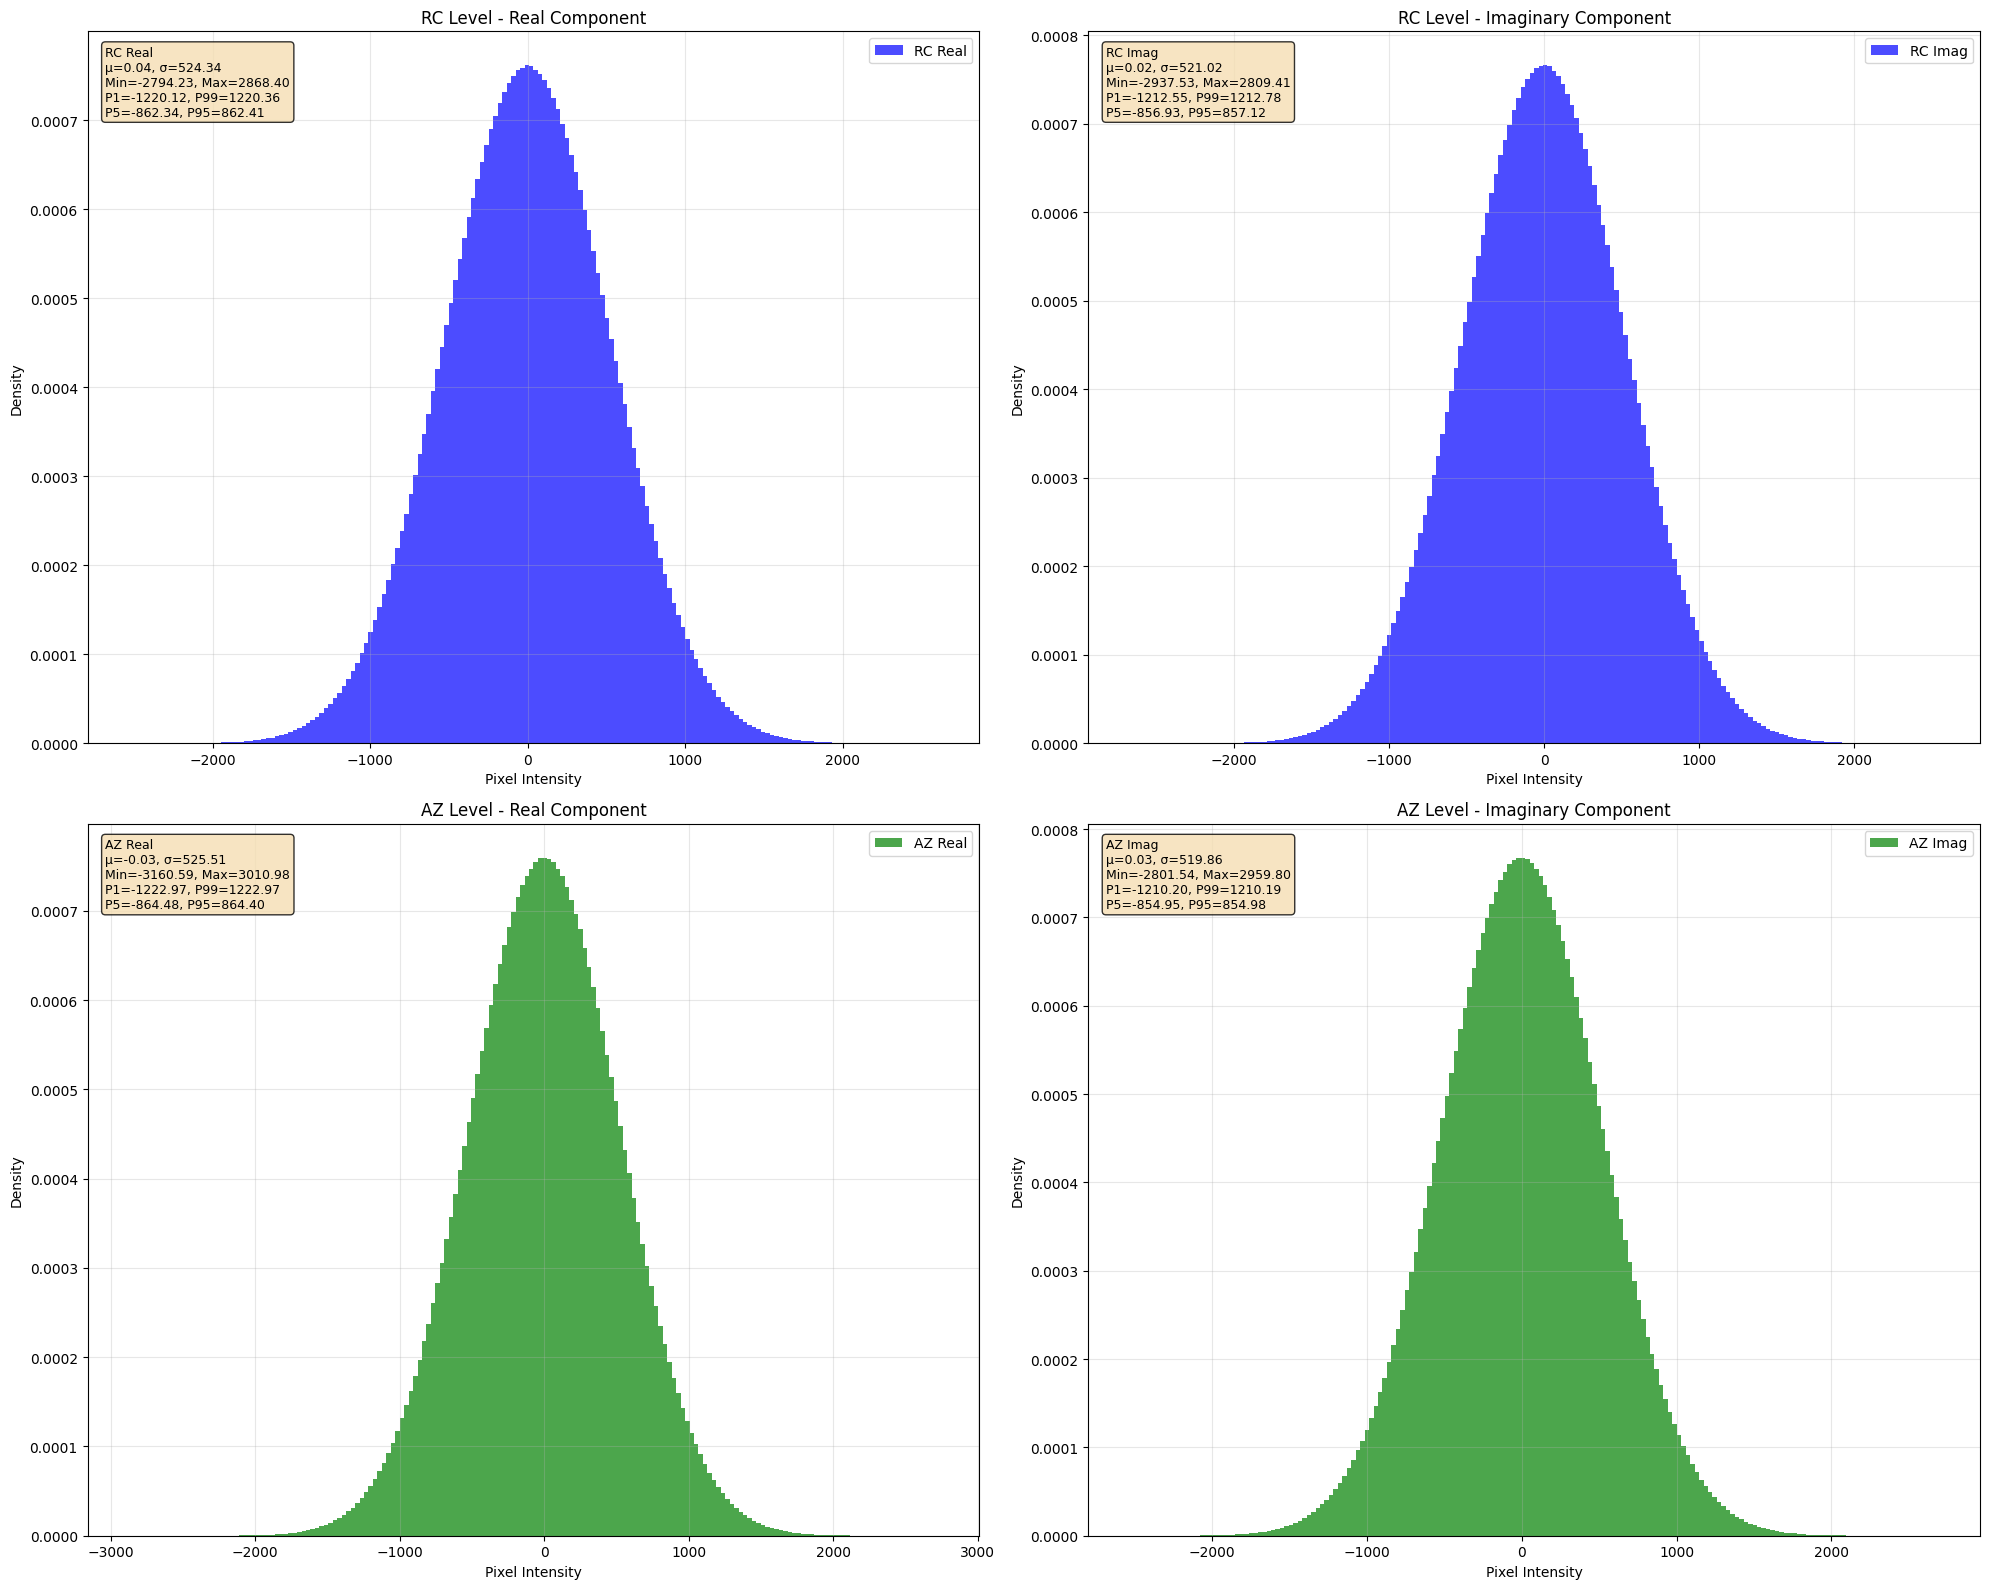

Trying to download file s1a-s6-raw-s-hh-20240729t050635-20240729t050656-054971-06b249.zarr/rc/c/0/1 from repo Maya4/PT2


s1a-s6-raw-s-hh-20240729t050635-20240729(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s6-raw-s-hh-20240729t050635-20240729t050656-054971-06b249.zarr/rc/c/1/1 from repo Maya4/PT2


s1a-s6-raw-s-hh-20240729t050635-20240729(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s6-raw-s-hh-20240729t050635-20240729t050656-054971-06b249.zarr/az/c/0/1 from repo Maya4/PT2


s1a-s6-raw-s-hh-20240729t050635-20240729(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Trying to download file s1a-s6-raw-s-hh-20240729t050635-20240729t050656-054971-06b249.zarr/az/c/1/1 from repo Maya4/PT2


s1a-s6-raw-s-hh-20240729t050635-20240729(…):   0%|          | 0.00/240M [00:00<?, ?B/s]

Displaying sample from product /Data/sar_focusing/PT2/s1a-s6-raw-s-hh-20240729t050635-20240729t050656-054971-06b249.zarr


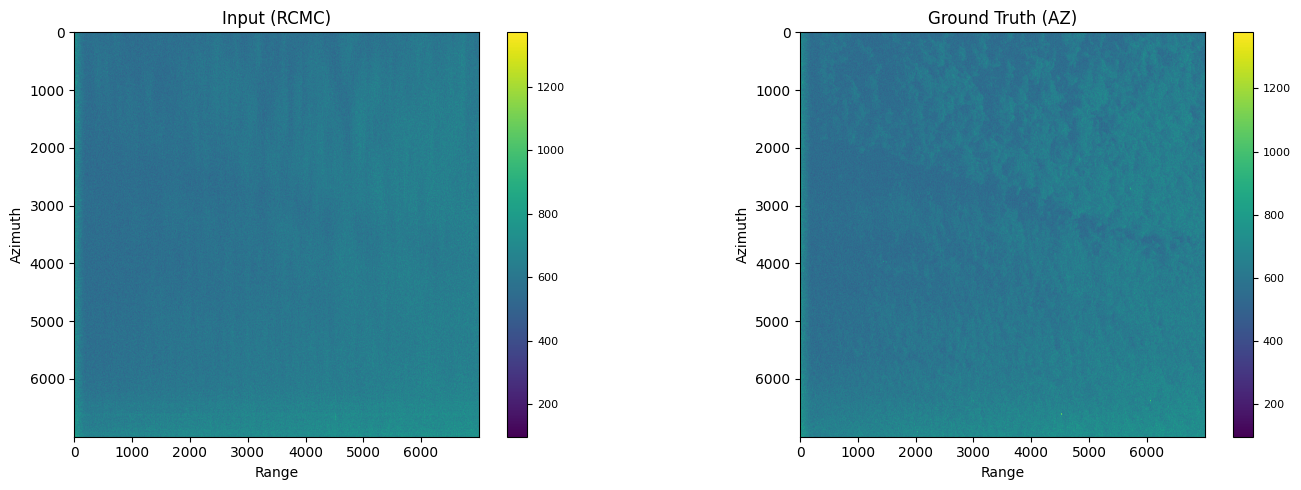

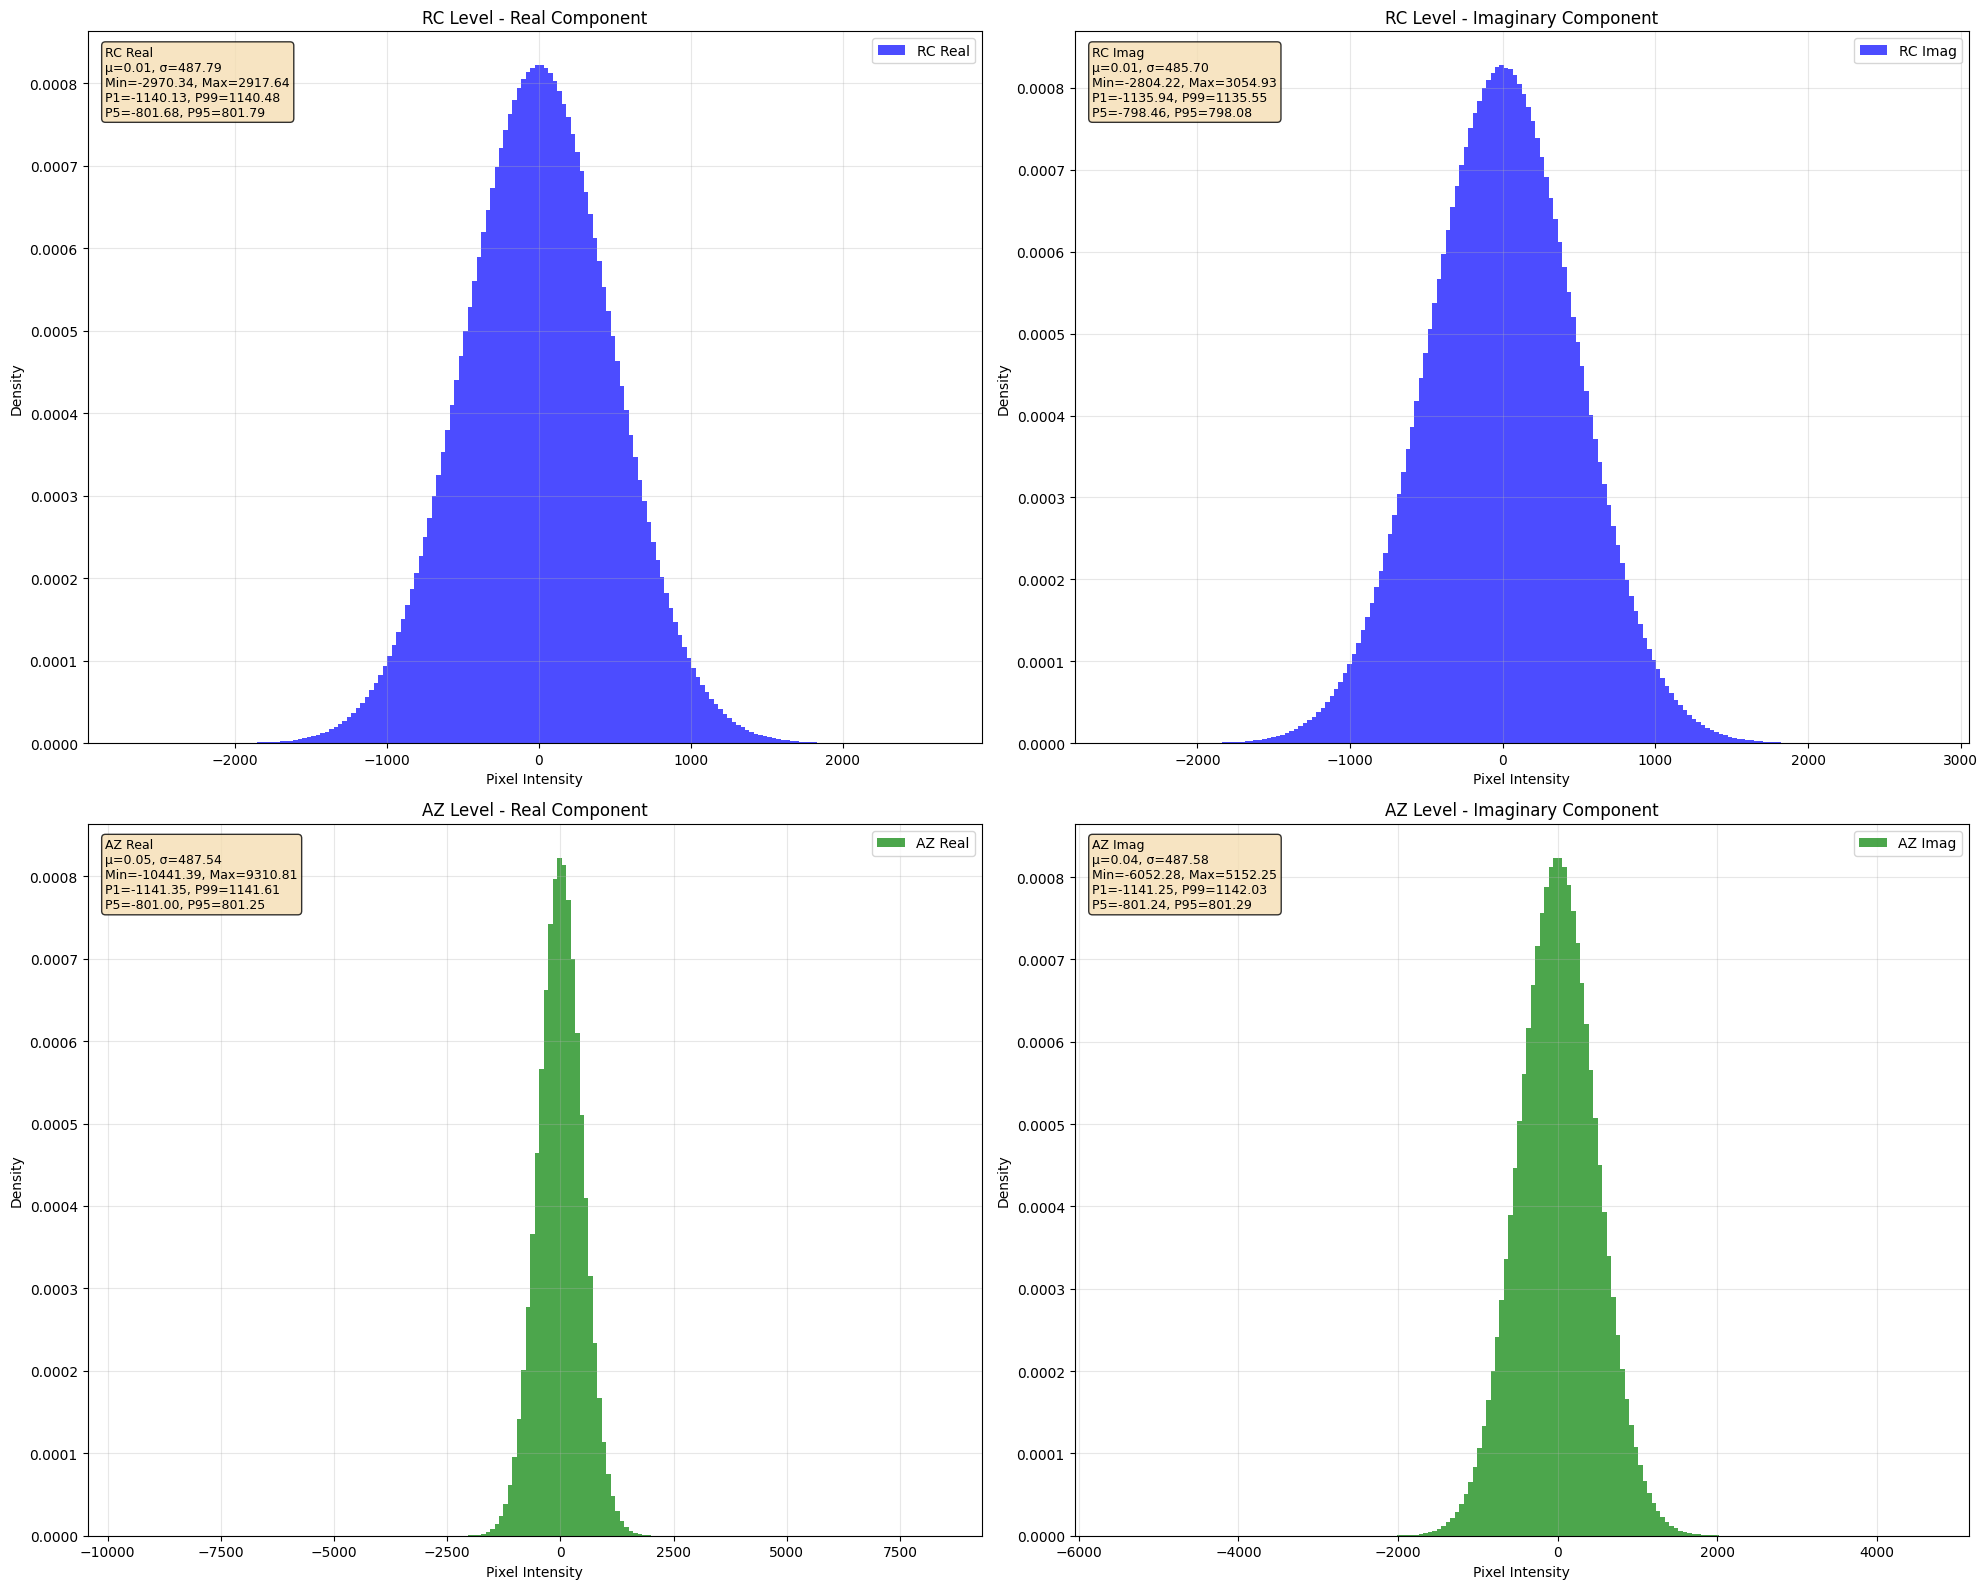

INFO:root:Reached max products limit: 10
INFO:root:Collected 10 samples from 10 products
INFO:root:Data collection completed!



Collected data summary:
Samples collected: 10
Products used: 10
RC real values: 10
RC imag values: 10
AZ real values: 10
AZ imag values: 10


In [8]:
# Collect data statistics
logger.info("Starting data collection...")
data_stats = collect_data_statistics(
    exploration_loader, 
    max_samples=5000,  
    max_products=10     
)

logger.info("Data collection completed!")
print(f"\nCollected data summary:")
print(f"Samples collected: {data_stats['samples_collected']}")
print(f"Products used: {data_stats['products_used']}")
print(f"RC real values: {len(data_stats['rc_real'])}")
print(f"RC imag values: {len(data_stats['rc_imag'])}")
print(f"AZ real values: {len(data_stats['az_real'])}")
print(f"AZ imag values: {len(data_stats['az_imag'])}")

INFO:root:Creating histograms for data exploration...


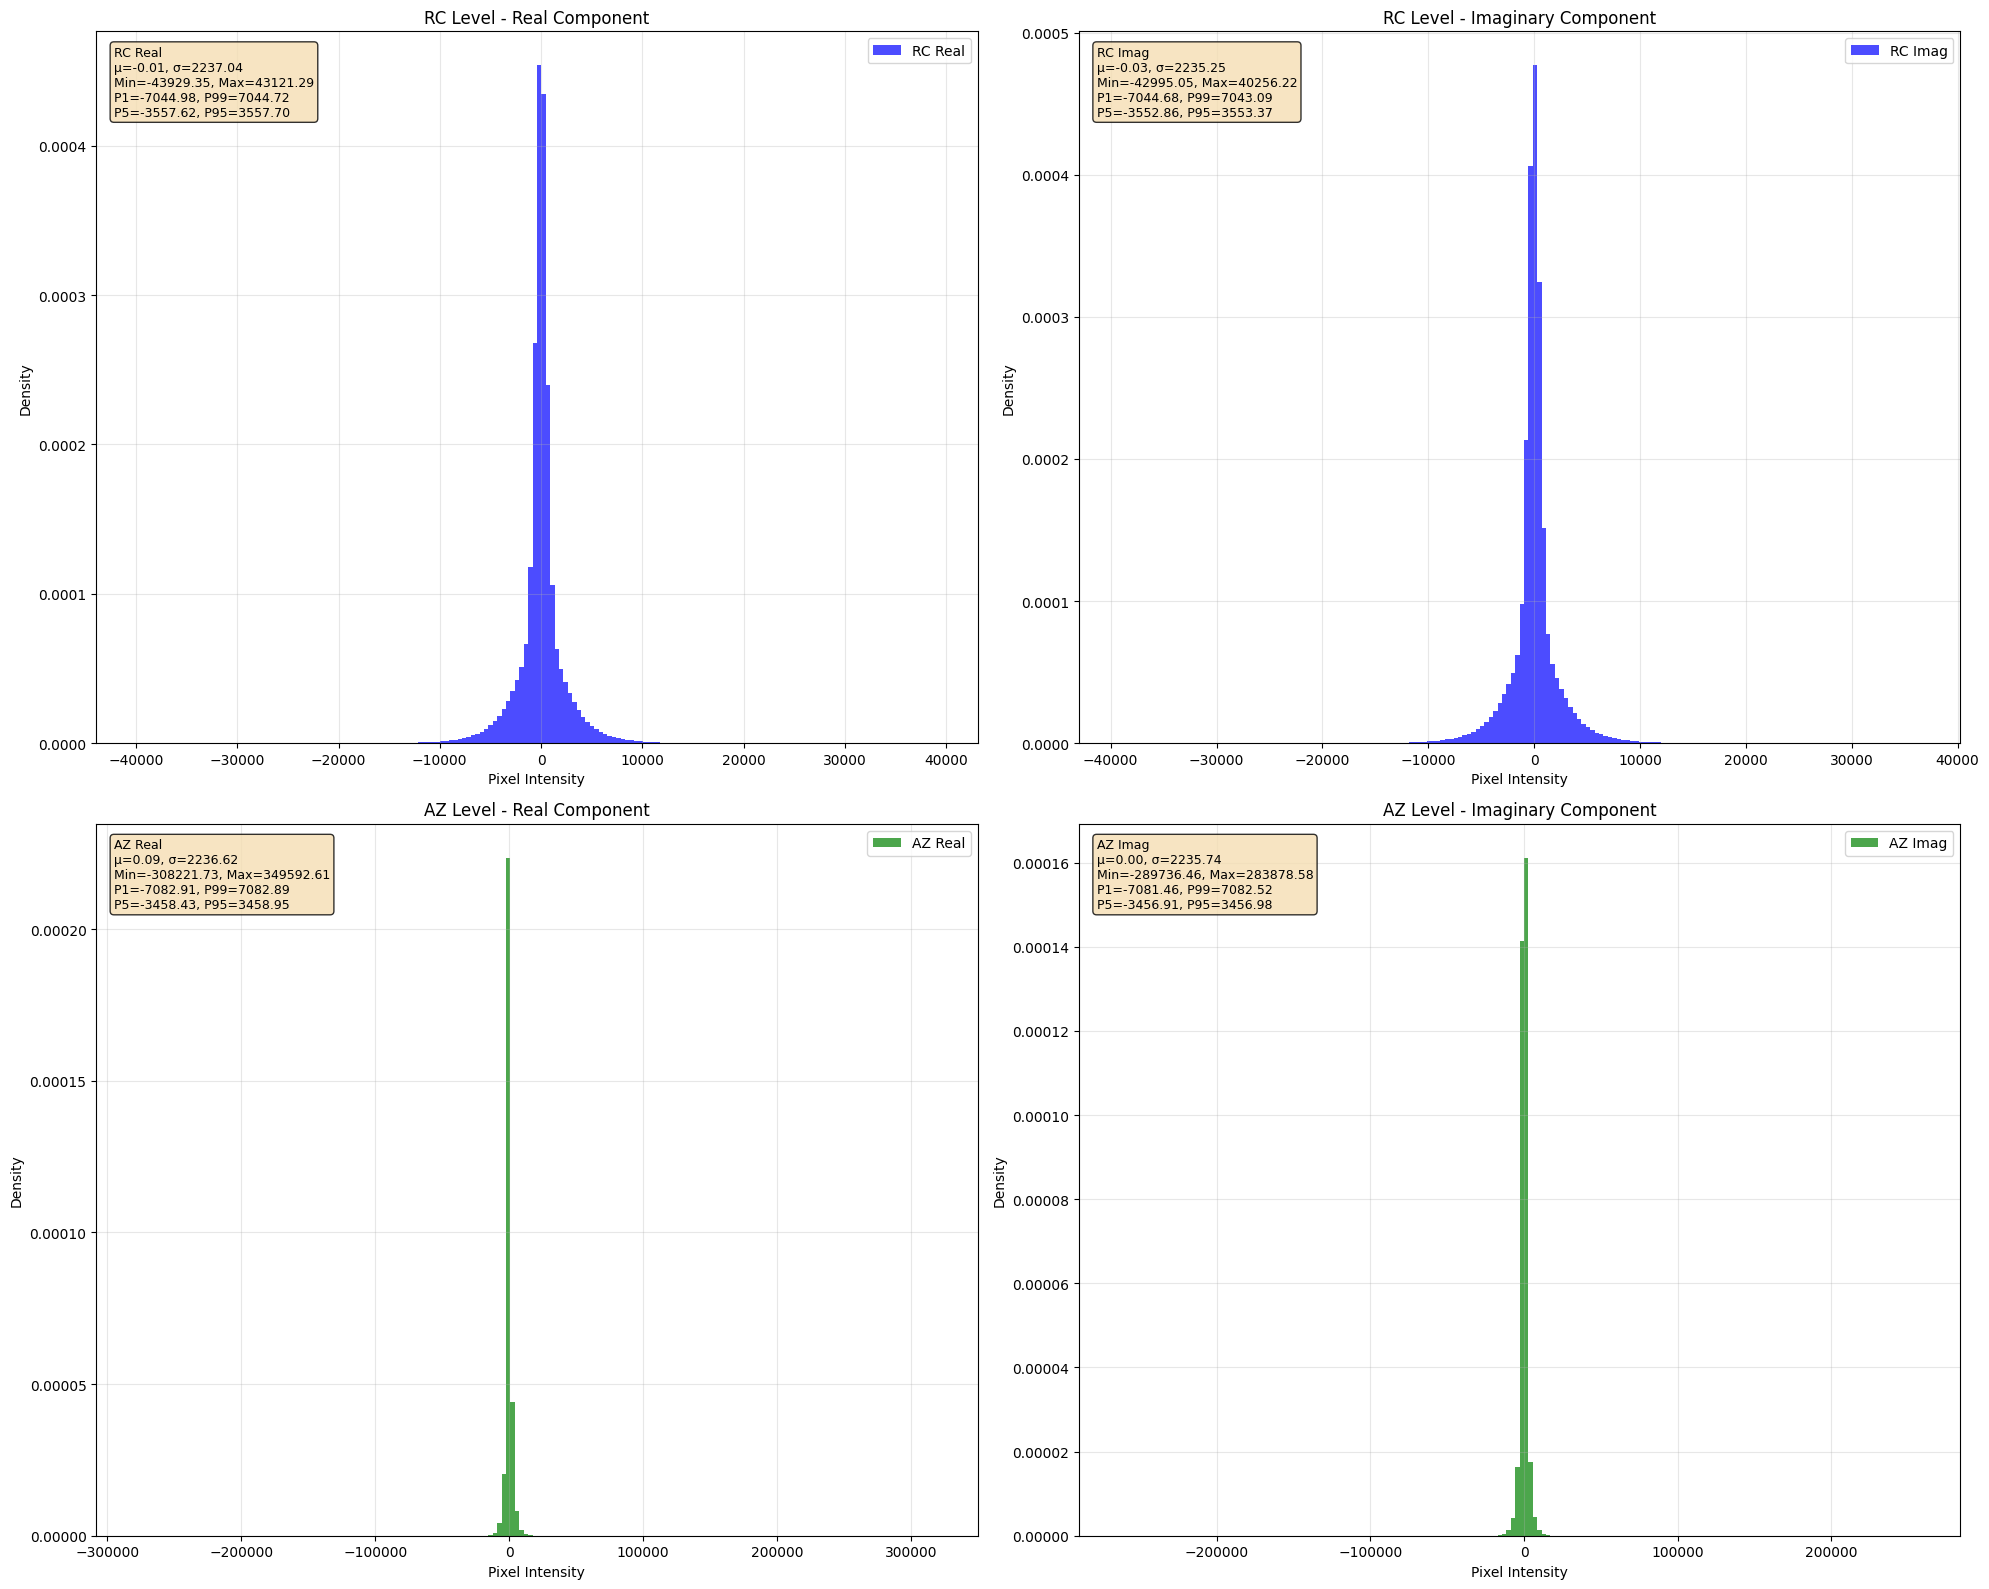

In [9]:
# Plot histograms
del exploration_loader
logger.info("Creating histograms for data exploration...")
aggregated_data_stats = {
    'rc_real': np.concatenate(data_stats['rc_real']) if data_stats['rc_real'] else np.array([]),
    'rc_imag': np.concatenate(data_stats['rc_imag']) if data_stats['rc_imag'] else np.array([]),
    'az_real': np.concatenate(data_stats['az_real']) if data_stats['az_real'] else np.array([]),
    'az_imag': np.concatenate(data_stats['az_imag']) if data_stats['az_imag'] else np.array([]),
    'samples_collected': data_stats['samples_collected'],
    'products_used': data_stats['products_used']
}   
del data_stats
fig = plot_data_exploration_histograms(aggregated_data_stats, figsize=(20, 16), bins=200)


## Statistical Analysis and Normalization Recommendations

In [10]:
def calculate_normalization_bounds(data: np.ndarray, method: str = 'percentile') -> Tuple[float, float]:
    """
    Calculate normalization bounds using different methods.
    
    Args:
        data: Input data array
        method: Method to use ('percentile', 'std', 'minmax', 'robust')
        
    Returns:
        Tuple of (min_bound, max_bound)
    """
    if len(data) == 0:
        return 0.0, 1.0
    
    if method == 'percentile':
        # Use 1st and 99th percentiles to exclude extreme outliers
        return float(np.percentile(data, 1)), float(np.percentile(data, 99))
    elif method == 'percentile_5_95':
        # More conservative: 5th and 95th percentiles
        return float(np.percentile(data, 5)), float(np.percentile(data, 95))
    elif method == 'std':
        # Mean ± 3 standard deviations (captures ~99.7% of data)
        mean = np.mean(data)
        std = np.std(data)
        return float(mean - 3*std), float(mean + 3*std)
    elif method == 'robust':
        # Median ± 3 * MAD (Median Absolute Deviation)
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        return float(median - 3*mad), float(median + 3*mad)
    elif method == 'minmax':
        # Absolute min/max (includes all outliers)
        return float(np.min(data)), float(np.max(data))
    else:
        raise ValueError(f"Unknown method: {method}")

# Calculate normalization bounds for all data
methods = ['percentile', 'percentile_5_95', 'std', 'robust', 'minmax']
data_types = {
    'RC Real': aggregated_data_stats['rc_real'],
    'RC Imag': aggregated_data_stats['rc_imag'],
    'AZ Real': aggregated_data_stats['az_real'],
    'AZ Imag': aggregated_data_stats['az_imag']
}

print("\n" + "="*80)
print("NORMALIZATION BOUNDS ANALYSIS")
print("="*80)

normalization_recommendations = {}

for data_name, data in data_types.items():
    if len(data) == 0:
        continue
        
    print(f"\n{data_name} Data Analysis:")
    print("-" * 40)
    
    # Basic statistics
    print(f"Samples: {len(data):,}")
    print(f"Mean: {np.mean(data):.4f}")
    print(f"Std: {np.std(data):.4f}")
    print(f"Min: {np.min(data):.4f}")
    print(f"Max: {np.max(data):.4f}")
    print(f"Median: {np.median(data):.4f}")
    
    print("\nNormalization Bounds by Method:")
    method_bounds = {}
    
    for method in methods:
        min_bound, max_bound = calculate_normalization_bounds(data, method)
        method_bounds[method] = (min_bound, max_bound)
        
        # Calculate percentage of data that would be clipped
        below_min = np.sum(data < min_bound) / len(data) * 100
        above_max = np.sum(data > max_bound) / len(data) * 100
        total_clipped = below_min + above_max
        
        print(f"  {method:15s}: [{min_bound:8.2f}, {max_bound:8.2f}] "
              f"(clips {total_clipped:5.2f}% of data)")
    
    normalization_recommendations[data_name] = method_bounds

print("\n" + "="*80)
print("RECOMMENDED NORMALIZATION VALUES")
print("="*80)

# Provide specific recommendations
print("\nBased on the analysis, here are the recommended normalization bounds:")
print("\n1. CONSERVATIVE APPROACH (Percentile 5-95):")
print("   - Preserves most detail, clips ~10% of extreme values")
for data_name, bounds in normalization_recommendations.items():
    if 'percentile_5_95' in bounds:
        min_val, max_val = bounds['percentile_5_95']
        print(f"   - {data_name:12s}: MIN = {min_val:8.2f}, MAX = {max_val:8.2f}")

print("\n2. BALANCED APPROACH (Percentile 1-99):")
print("   - Good balance between detail preservation and outlier handling")
for data_name, bounds in normalization_recommendations.items():
    if 'percentile' in bounds:
        min_val, max_val = bounds['percentile']
        print(f"   - {data_name:12s}: MIN = {min_val:8.2f}, MAX = {max_val:8.2f}")

print("\n3. ROBUST APPROACH (Median ± 3*MAD):")
print("   - Robust to outliers, good for noisy data")
for data_name, bounds in normalization_recommendations.items():
    if 'robust' in bounds:
        min_val, max_val = bounds['robust']
        print(f"   - {data_name:12s}: MIN = {min_val:8.2f}, MAX = {max_val:8.2f}")


NORMALIZATION BOUNDS ANALYSIS

RC Real Data Analysis:
----------------------------------------
Samples: 490,000,000
Mean: -0.0056
Std: 2237.0440
Min: -43929.3506
Max: 43121.2862
Median: 0.0315

Normalization Bounds by Method:
  percentile     : [-7044.98,  7044.72] (clips  2.00% of data)
  percentile_5_95: [-3557.62,  3557.70] (clips 10.00% of data)
  std            : [-6711.14,  6711.13] (clips  2.32% of data)
  robust         : [-1845.01,  1845.07] (clips 22.68% of data)
  minmax         : [-43929.35, 43121.29] (clips  0.00% of data)

RC Imag Data Analysis:
----------------------------------------
Samples: 490,000,000
Mean: -0.0302
Std: 2235.2527
Min: -42995.0497
Max: 40256.2177
Median: -0.0509

Normalization Bounds by Method:
  percentile     : [-7044.68,  7043.09] (clips  2.00% of data)
  percentile_5_95: [-3552.86,  3553.37] (clips 10.00% of data)
  std            : [-6705.79,  6705.73] (clips  2.33% of data)
  robust         : [-1837.41,  1837.31] (clips 22.72% of data)
  minmax

## Summary and Conclusions

This analysis provides data-driven normalization bounds for SAR data processing:

1. **Conservative Approach (5-95 percentiles)**: Preserves the most detail but may retain some outliers
2. **Balanced Approach (1-99 percentiles)**: Good balance between detail preservation and outlier removal
3. **Robust Approach**: Uses median and MAD, very robust to extreme outliers

The recommended approach depends on your specific use case:
- For training models: Use balanced approach (1-99 percentiles)
- For visualization: Use conservative approach (5-95 percentiles)
- For noisy data: Use robust approach (median ± 3*MAD)

These bounds should replace the current hard-coded values and provide better normalization that preserves important signal characteristics while handling outliers appropriately.